# Background

English-language folk songs have a long tradition and have changed over time. Songs are not easily idenifiable by name alone, and lyrics often have variations. Steve Roud began indexing his own collection in the 1970s, and his Roud Index has become the standard for grouping together different versions of the same song. He is still indexing as of 2023.

Could a machine learning algorithm hope to match his skill? Given the lyrics, would it choose the same groupings of songs, where the line between "same" and "different" is fuzzy? Could it help with future indexing?

# Data extraction

## Source overview

Although the Roud index is a lyrics-based classification system (rather than tune-based), the officially-hosted index at vwml.com does not contain lyric transcriptions as a standard data field. Some lyrics are accessible online, presented in scanned images of historical collections, others on linked external sites, others not at all. 

So the first challenge is to get a dataset with enough full lyrics and Roud numbers in combination. The main contenders for the source of this data are Mudcat and The Traditional Ballad Index, both well-established online song databases.

### Mudcat 
- Project focuses on song lyrics and tunes, but also contains Roud numbers for approximately 300 songs.
- Data and formats:
    - Digitrad (DT) download: askSam MS-DOS database (last updated in 2002)
    - Song web pages
    - Forum posts containing songs

### The Traditional Ballad Index 
- Project focuses on cataloguing*, but also has supplementary lyrics for approximately 1110 songs.
- Data and formats:
    - The Ballad Index Software download: Claris Filemaker database
    - Song web pages (without lyrics)
    - The Ballad Index (BI) and The Supplemental Tradition (ST) (lyrics) as HTML or TXT lists

&ast; This is a similar to approach to Roud, but focused on the basic unit of a song rather than its individual instances (e.g. variations, songbook entries or performances), and therefore uses song titles as its main identifiers, with keywords and first line for disambiguation.


## Extraction process

Neither the Ballad Index (which would have included ST lyrics) nor the Mudcat Digitrad downloadable databases will open. 

In order to link Roud numbers to lyrics, I therefore need to work with the `.txt` version of the Ballad Index (which does not include ST) as my base for a new database, extract the records from it, then join ST and DT's lyrics to these records using the various references provided in each data source.

### Linking data: Filenames as keys

To link the lyrics correctly to the main data of the BI, I need fields that act as idenifiers/keys:

#### BI filename
Alphanumeric filename serving as an identifier for all BI records, also referenced by ST lyrics where they exist.

#### DT filename
8.3 filename (all-caps without extension) serving as an identifier for all DT records, also sometimes referenced in BI. 
* Note: in a minority of cases, modified DT filenames also appear to be used as the main BI filenames ('DT' + first six characters in lower or title case), e.g. 'DToatsbe' is the same as 'OATSBEAN' in DT). However, this occasionally disagrees with the stated DT filename for the BI record.

#### Other numbers and references:
**DT number:** Many records in DT and BI also contain a 'DT #'. This number is not the same as the DT file, and, contrary to my first assumption, nor does it correspond to the SongID in Mudcat URLs (e.g. http://mudcat.org/@displaysong.cfm?SongID=329). It appears to be another grouping system developed by Mudcat and intended to extend Child numbers (see below): "*Francis J. Child only went up to 305--since there are ballads he didn't include, you may notice some numbers like DT #510 . Not to worry--it just helps locate variants*".

**Roud number:** Found in BI only (at least as far as downloadable data is concerned - song lyrics on Mudcat's website do often include this).

**Child number:** The Child Ballads were the first large collection of songs of English and Scottish origin collected by Francis James Child in the 1800s. Many songs contained multiple versions. Child  numbers (1-305) are often referenced in folk song sources.

**Laws number:** George Malcolm Laws and the American Folklore Society published a collection of traditional songs in 1957. Laws numbers contain an initial letter which indicates the song's theme, e.g. 'M: Ballads of Family Opposition to Lovers'. Laws numbers are also commonly referenced.

**Other collections:** References to other collections are sometimes found, and some of these also have their own numbers for songs.

### Extraction quantity targets (BI, ST, DT)

Based on text editor finds I estimate I can extract approximately the following data [with comparisons for a Google domain search of online versions]:
- BI: 30445 song record files, of which (in combination):
    - 14213 are stubs for variants that only refer to other songs
    - 2623 refer to DT files (lyrics) [compare: Google search: 357]; 356 have BI filenames referring to a DT filename
    - 1180 refer to ST files (lyrics) [compare: Google search: 395]
    - 12126 of these contain Roud index numbers [compare: Google search: 2700]
- ST: 1229 lyrics referencing 1136 BI files [no separate online version]
- DT: 8932 song record files (lyrics)
    - only 1 contains a Roud number [compare: Google search of newer web version: 435]

## BI (Ballad Index)

Below is a preview of `balldidx.txt`. The text version of the Ballad Index file is tricky to work with as entries are presented as a list with inconsistent headings and mixed data. 

I first used a text editor to place colons before Roud numbers and DT filenames, so that they could be more easily matched. (This could have been perhaps better achieved with regex, although to begin I decided to save myself a step as they were formatted inconsistently.)

Here it is interesting to note that the BI database also references Mudcat's DT filenames, for example 'DT, MASS1913*' above. This means we can also supplement lyrics by cross-referencing this data.

I then used a script with regular expressions to import while doing the following:
- split song records at the marker '==='
- extract only the values for 'name', 'description', 'earliest_date', found_in', 'keywords', 'cross_references', 'roud', 'bi_file', 'st_file', and 'dt_file'
- split and store reference song name and filename information in one-line stub records that only serve to reference a main song
- extract only the earliest year found in the 'EARLIEST_FOUND:' field which contained mixed data
- replace empty fields with NumPy `NaN` to allow for better data manipulation

These are stored in `df_bi`.

Target: 30445 file records |
Output: 30418 file records

In [1]:
#BI extraction
import re
import pandas as pd
import numpy as np
import pickle

# get file data
file_path = './Data/BalladIndex/txt/BDIDXTXT/balldidxedited.txt'
with open(file_path, 'r') as file:
    data = file.read()

# define record boundary pattern (handle both cases with optional newline)
record_pattern = re.compile(r'(?<=\n)?===\n(.*?)(?=\n===)', re.DOTALL)

# feed pattern and data to a callable iterator to get `records` matches
records = re.finditer(record_pattern, data)

# define the field patterns, including the special pattern for stubs
field_patterns = {
    'name': r'NAME: (.*?)(?:: see |\n|$)',
    'key_name': r'(?<=: see )([^:(\n]*)',  # extract main song for stubs
    'description': r'DESCRIPTION: (.*?)(?:\nAUTHOR: |\nEARLIEST_DATE: |\nKEYWORDS: |\nFOUND_IN: |\nREFERENCES: |\nSAME_TUNE: |\nST: |\nDT: |\nROUD: |\nRECORDINGS: |\nCROSS_REFERENCES: |\nNOTES: |\nLast updated|$)',
    'author': r'AUTHOR: (.*?)(?:\n|$)',
    'earliest_date': r'EARLIEST_DATE: (.*?)(?:\n|$)',
    'long_description': r'LONG_DESCRIPTION: (.*?)(?:\n[A-Z]+: |Last updated|$)',
    'keywords': r'KEYWORDS: (.*?)(?:\n|$)',
    'found_in': r'FOUND_IN: (.*?)(?:\n|$)',
    'references': r'REFERENCES: (.*?)(?:\n[A-Z]+: |Last updated|$)',
    'same_tune': r'SAME_TUNE: (.*?)(?:\n|$)',
    'st_file': r"(?<=\nST: )(.*?)(?=\n)",
    'dt_file': r"(?<=\nDT: )(.*?)(?=\n)",
    'roud': r'ROUD: (.*?)(?:\n|$)',
    'recordings': r'RECORDINGS:\n((?:(?!CROSS_REFERENCES|NOTES|Last updated).)*)(?:\n|$)',
    'cross_references': r'CROSS_REFERENCES:\n((?:(?!NOTES|Last updated).)*)(?:\n|$)',
    'notes': r'NOTES: (.*?)(?:\nLast updated|$)',
    'last_updated': r'Last updated in version (.*?)(?:\n|$)',
    'bi_file': r"File: (.*?)(?=\nNAME:|\n===|\nLast updated|$)"
}

# initialise a list to store dicts of extracted `record_data`
records_data = []

# loop over each of the `records` from the iterator
for record in records:
    # check if it is a stub record
    is_stub = ': see ' in record.group(1)
    if is_stub:
        # handle stub records separately
        stub_data = re.search(r'NAME: (.*?): see (.*?) \(File: (.*?)\)', record.group(1))
        if stub_data:
            name, key_name, bi_file = stub_data.groups()
            record_data = {
                'name': name.strip(),
                'key_name': key_name.strip(),
                'bi_file': bi_file.strip()
            }
    else:
        # iterate over the patterns and `search` them, storing match group 1 with its field in `record_data`
        record_data = {}
        for field, pattern in field_patterns.items():
            value = re.search(pattern, record.group(1))
            if value:
                value = value.group(1).strip()
                # for dates: get earliest year and dump the rest
                if field == 'earliest_date':
                    years = re.findall(r'\b\d{4}\b', value)
                    if years:
                        value = min(map(int, years))
            else:
                value = ""
            record_data[field] = value

    # add each finished record to the list
    records_data.append(record_data)

# make the data into a df, fill empty fields with `NaN`s
df_extracted = pd.DataFrame(records_data)

df_bi = df_extracted[['name', 'key_name', 'keywords', 'description', 'long_description', 'found_in', 'bi_file', 'st_file', 'dt_file', 'roud']].copy()
df_bi.replace('', np.nan, inplace=True)
df_bi.dropna(how='all', inplace=True)
df_bi

name  \
0                      10,000 Years Ago   
1                10th MTB Flotilla Song   
2                            13 Highway   
3                              151 Days   
4      1861 Anti Confederation Song, An   
...                                 ...   
30412                              Zula   
30413                 Zulu Warrior, The   
30414                     Zum Gali Gali   
30415                       Zutula Dead   
30416                Zwei Soldaten, Die   

                                                key_name  \
0      I Was Born About Ten Thousand Years Ago (Bragg...   
1                                      Fred Karno's Army   
2                                                    NaN   
3                             Hundred and Fifty-One Days   
4                                Anti-Confederation Song   
...                                                  ...   
30412                                                NaN   
30413                                                NaN   
30414                                                NaN   
30415                                                NaN   
30416                                                NaN   

                                                keywords  \
0                                                    NaN   
1                                                    NaN   
2          grief love promise nonballad lover technology   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
30412                   love rejection separation travel   
30413                        nonballad nonsense campsong   
30414                           foreignlanguage campsong   
30415                                  death poison food   
30416  foreignlanguage soldier food homicide suicide ...   

                                             description long_description  \
0                                                    NaN              NaN   
1                                                    NaN              NaN   
2      "I went down 13 highway, Down in my baby's doo...              NaN   
3                                                    NaN              NaN   
4                                                    NaN              NaN   
...                                                  ...              ...   
30412  "Thou lov'st another, Zula, Thou lovest him al...              NaN   
30413  "I-kama zimba zimba zayo I-kama zimba zimba ze...              NaN   
30414  Hebrew. "Zum, gali-gali-gali, Zum gali-gali, Z...              NaN   
30415  A nice girl gave Zutula bitter casava to eat a...              NaN   
30416  German. "Es war einmal zwei Bauersohn, Die hat...              NaN   

                    found_in   bi_file st_file dt_file   roud  
0                        NaN      R410     NaN     NaN    NaN  
1                        NaN  NeFrKaAr     NaN     NaN    NaN  
2                     US(SE)   Rc13Hwy     NaN     NaN  29487  
3                        NaN   Colq060     NaN     NaN    NaN  
4                        NaN     FJ028     NaN     NaN    NaN  
...                      ...       ...     ...     ...    ...  
30412                 US(So)   Brne049     NaN     NaN  11330  
30413                    NaN  ACFF061A     NaN     NaN    NaN  
30414                    NaN  ACSF314Z     NaN     NaN    NaN  
30415  West Indies(Trinidad)  RcALZuDe     NaN     NaN    NaN  
30416                 US(MW)    RDL056     NaN     NaN    NaN  

[30417 rows x 10 columns]

### Stub inheritance

Next I want to make stubs inherit Roud number and file references from their parent entries. I do this via a lookup table containing only those 'bi_file' entries that have the other data associated:

In [2]:
# make a lookup table where bi_file points to st_file, dt_file and roud
df_file_lookup = df_bi[['bi_file', 'st_file', 'dt_file', 'roud']].dropna(subset=['roud', 'st_file', 'dt_file'], how='all')
df_file_lookup

bi_file           st_file    dt_file   roud
2       Rc13Hwy               NaN        NaN  29487
5      FSWB306A               NaN  MASS1913*  17663
8       Hopk112               NaN        NaN  29405
11      Hopk039               NaN        NaN  29404
12      Hopk046               NaN        NaN  29403
...         ...               ...        ...    ...
30399    San449     San449 (Full)        NaN  12174
30403  SuSm091B               NaN        NaN  20694
30405   Dett196               NaN        NaN  15233
30406    Fus214  Fus214 (Partial)        NaN  16373
30412   Brne049               NaN        NaN  11330

[12420 rows x 4 columns]

In [3]:
# fill missing values from lookup table
df_bi['roud'] = df_bi['roud'].fillna(df_bi['bi_file'].map(df_file_lookup['roud']))
df_bi['st_file'] = df_bi['st_file'].fillna(df_bi['bi_file'].map(df_file_lookup['st_file']))
df_bi['dt_file'] = df_bi['dt_file'].fillna(df_bi['bi_file'].map(df_file_lookup['dt_file']))

In [4]:
df_bi

name  \
0                      10,000 Years Ago   
1                10th MTB Flotilla Song   
2                            13 Highway   
3                              151 Days   
4      1861 Anti Confederation Song, An   
...                                 ...   
30412                              Zula   
30413                 Zulu Warrior, The   
30414                     Zum Gali Gali   
30415                       Zutula Dead   
30416                Zwei Soldaten, Die   

                                                key_name  \
0      I Was Born About Ten Thousand Years Ago (Bragg...   
1                                      Fred Karno's Army   
2                                                    NaN   
3                             Hundred and Fifty-One Days   
4                                Anti-Confederation Song   
...                                                  ...   
30412                                                NaN   
30413                                                NaN   
30414                                                NaN   
30415                                                NaN   
30416                                                NaN   

                                                keywords  \
0                                                    NaN   
1                                                    NaN   
2          grief love promise nonballad lover technology   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
30412                   love rejection separation travel   
30413                        nonballad nonsense campsong   
30414                           foreignlanguage campsong   
30415                                  death poison food   
30416  foreignlanguage soldier food homicide suicide ...   

                                             description long_description  \
0                                                    NaN              NaN   
1                                                    NaN              NaN   
2      "I went down 13 highway, Down in my baby's doo...              NaN   
3                                                    NaN              NaN   
4                                                    NaN              NaN   
...                                                  ...              ...   
30412  "Thou lov'st another, Zula, Thou lovest him al...              NaN   
30413  "I-kama zimba zimba zayo I-kama zimba zimba ze...              NaN   
30414  Hebrew. "Zum, gali-gali-gali, Zum gali-gali, Z...              NaN   
30415  A nice girl gave Zutula bitter casava to eat a...              NaN   
30416  German. "Es war einmal zwei Bauersohn, Die hat...              NaN   

                    found_in   bi_file st_file dt_file   roud  
0                        NaN      R410     NaN     NaN    NaN  
1                        NaN  NeFrKaAr     NaN     NaN    NaN  
2                     US(SE)   Rc13Hwy     NaN     NaN  29487  
3                        NaN   Colq060     NaN     NaN    NaN  
4                        NaN     FJ028     NaN     NaN    NaN  
...                      ...       ...     ...     ...    ...  
30412                 US(So)   Brne049     NaN     NaN  11330  
30413                    NaN  ACFF061A     NaN     NaN    NaN  
30414                    NaN  ACSF314Z     NaN     NaN    NaN  
30415  West Indies(Trinidad)  RcALZuDe     NaN     NaN    NaN  
30416                 US(MW)    RDL056     NaN     NaN    NaN  

[30417 rows x 10 columns]

### Clean and split multiple 'dt_file' entries

Next I need to handle cases where more than one DT filename is associated with each record, to allow for correct data merging later. I will assign the duplicates to new rows, first discarding DT numbers and other characters that do not constitute a valid DT filename.

In [5]:
# clean up so only valid DT filenames remain, separated by a space
def clean_filenames(df, column_name):
    # reg pattern for valid filenames (5-8 characters, all in capitals)
    pattern = r'\b[A-Z0-9]{5,8}\b'
    
    # function for cleaning each cell
    def clean_cell(cell_value):
        if pd.isna(cell_value):
            return np.nan
        else:
            # find valid filenames in the cell
            matches = re.findall(pattern, cell_value)
            # return them as a space-separated string
            cleaned_value = ' '.join(matches)
            return cleaned_value
    
    # call cleaning function on the column provided in args
    df[column_name] = df[column_name].apply(clean_cell)
    return df

df_bi_cleaned = clean_filenames(df_bi.copy(), 'dt_file')


A visual check suggests the cleaning worked:

In [6]:
df_bi_cleaned[['name', 'bi_file', 'dt_file']].loc[df_bi_cleaned.dt_file.str.contains(' ', na=False)].sort_values(by='dt_file')

name   bi_file  \
13779  Johnny Fill Up the Bowl (In Eighteen Hundred a...      R227   
176                                   Admiral Benbow (I)    PBB076   
15110                            Let Me In This Ae Nicht  DTaenich   
198                                       After the Ball    SRW169   
223                                           Aiken Drum    OO2007   
...                                                  ...       ...   
28425                   Weaver and the Factory Maid, The  DTwvfact   
3176                            Brisk Young Butcher, The  DTxmasgo   
22203  Rare Willie Drowned in Yarrow, or, The Water o...      C215   
30179                            Young Allan [Child 245]      C245   
23899                   Seventeen Come Sunday [Laws O17]      LO17   

                        dt_file  
13779          ABEWASH FORBALES  
176           ADBENBOW ADBENBW2  
15110          AENICHT COLDRAIN  
198           AFTRBALL UNFORTU6  
223            AIKDRUM AIKDRUM3  
...                         ...  
28425         WVFACTGL WEAVFACT  
3176          XMASGOOS XMASGOO2  
22203           YARROW2 YARROW3  
30179          YNGALAN YNGALAN2  
23899  YONHIGH ROCKYMT TROOPRM2  

[450 rows x 3 columns]

Now to split the valid filenames into their own rows and examine the changed rows:

In [7]:
# split rows
def separate_filenames(df, column_name):
    # empty DataFrame to store the results
    new_df = pd.DataFrame(columns=df.columns)
    
    # function to split the multiple filenames into new rows
    def split_multiple_filenames(row):
        nonlocal new_df
        if pd.notna(row[column_name]):
            filenames = row[column_name].split()
            for filename in filenames:
                new_row = row.copy()
                new_row[column_name] = filename
                new_df = new_df.append(new_row, ignore_index=True)
        else:
            new_df = new_df.append(row, ignore_index=True)  # Include rows with NaN filenames
    
    # apply the splitting function to the define column
    df.apply(split_multiple_filenames, axis=1)
    return new_df

df_bi_separated = separate_filenames(df_bi_cleaned, 'dt_file')

/tmp/ipykernel_158075/1738651564.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)  # Include rows with NaN filenames
/tmp/ipykernel_158075/1738651564.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_row, ignore_index=True)


In [8]:
df_bi_separated[df_bi_separated.duplicated(subset='bi_file', 
keep=False)].dropna(subset='dt_file').sort_values(by='dt_file')[['name', 'bi_file', 'dt_file']]

name   bi_file   dt_file
85                            Abdul the Bulbul Emir (II)     EM210  ABDULBL2
84                             Abdul the Bulbul Emir (I)    LxA341  ABDULBUL
48                                   A-Begging I Will Go      K217   ABEGGIN
14132  Johnny Fill Up the Bowl (In Eighteen Hundred a...      R227   ABEWASH
5795                                 David's Lamentation  FSWB412B   ABSALON
...                                                  ...       ...       ...
6848              Drummer Boy of Waterloo, The [Laws J1]      LJ01   YOUNGED
14832                Kingdom Coming (The Year of Jubilo)      R230  YRJUBILO
31061                          Zack, the Mormon Engineer   BRaF444  ZACKMORM
31067                          Zebra Dun, The [Laws B16]      LB16  ZEBRADUN
31064                      Zeb Tourney's Girl [Laws E18]      LE18  ZEBTURNY

[2489 rows x 3 columns]

#### Extract DT filenames from BI filenames
The next stage is to extract possible DT filenames from the bi_file entries. I will match these later on the DT data. Of the entries with BI filenames with this 'DTxxxxxx' pattern, 168 are missing DT filenames:

In [9]:
# filter rows where 'bi_file' starts with 'DT' and 'dt_file' is NaN
filtered_rows = df_bi_separated[df_bi_separated['bi_file'].str.startswith('DT', na=False) & df_bi_separated['dt_file'].isna()]
filtered_rows[['name', 'bi_file', 'dt_file']]

name   bi_file dt_file
432                            Allan Water  DTalanwa     NaN
493             Altoona Freight Wreck, The  DTwrck12     NaN
1133                 B'y' Sara Burned Down  DTBayous     NaN
1188       Back and Side Go Bare, Go Bare!  DTbcksid     NaN
1387             Banks of Allen Water, The  DTalanwa     NaN
...                                    ...       ...     ...
30282               Winter It Is Past, The  DTcurrki     NaN
30290               Winter's Gone and Past  DTcurrki     NaN
30307                          Wise Willie  DTcutywr     NaN
30455                 Wreck at Latona, The  DTwrck12     NaN
31046  Your Grannie and Your Other Grannie  DTgranbu     NaN

[168 rows x 3 columns]

I will strip 'DT' from these filenames and insert them into the column 'dt_file' for affected rows:

In [10]:
# fill 'dt_file' with the remainder of the string after 'DT'
df_bi_separated.loc[filtered_rows.index, 'dt_file'] = filtered_rows['bi_file'].str[2:]

df_bi_separated.loc[filtered_rows.index][['name', 'bi_file', 'dt_file']]

name   bi_file dt_file
432                            Allan Water  DTalanwa  alanwa
493             Altoona Freight Wreck, The  DTwrck12  wrck12
1133                 B'y' Sara Burned Down  DTBayous  Bayous
1188       Back and Side Go Bare, Go Bare!  DTbcksid  bcksid
1387             Banks of Allen Water, The  DTalanwa  alanwa
...                                    ...       ...     ...
30282               Winter It Is Past, The  DTcurrki  currki
30290               Winter's Gone and Past  DTcurrki  currki
30307                          Wise Willie  DTcutywr  cutywr
30455                 Wreck at Latona, The  DTwrck12  wrck12
31046  Your Grannie and Your Other Grannie  DTgranbu  granbu

[168 rows x 3 columns]

### Target check:

DT file references:

Target: 2623 | Initial output: 2605 | Post-split: 3264

In [11]:
df_bi_separated.query("dt_file.notna()").dt_file.count()

3432

ST file references:

Target: 1180 | Initial output: 1166 | Post-split: 1200

In [12]:
df_bi_separated.query("st_file.notna()").st_file.count()

1200

Roud references:

Target: 12126 | Initial output: 12004 | Post-split: 12656

In [13]:
df_bi_separated.query("roud.notna()").roud.count()

12656

Unique roud numbers: 11266 (note that this is inaccurate as multiple Roud numbers per field are sometimes still present)

In [14]:
# Number of unique Roud numbers amongst songs that now have lyrics matched:
df_bi_separated.query("roud.notna()").roud.nunique()

11266

The following query shows I would have 3782 songs with Roud numbers and lyrics, if I were to now join up the data and all the referenced lyrics files could be extracted. 

In [15]:
df_lyrics_available = df_bi_separated.query("(st_file.notna() | dt_file.notna()) & roud.notna()")
df_lyrics_available[['name', 'roud', 'bi_file', 'st_file', 'dt_file']].sort_values('roud')

name    roud  bi_file  \
10003                      Gypsy Laddie, The [Child 200]       1     C200   
10000                      Gypsy Laddie, The [Child 200]       1     C200   
10001                      Gypsy Laddie, The [Child 200]       1     C200   
10002                      Gypsy Laddie, The [Child 200]       1     C200   
10011                      Gypsy Laddie, The [Child 200]       1     C200   
...                                                  ...     ...      ...   
16274                        Lord Cornwallis's Surrender  V50597  SBoA088   
17588                            Memory of the Dead, The   V5143   PGa039   
25860                          Star-Spangled Banner, The   V5200   MKr015   
6797   Drive the Cold Winter Away (In Praise of Chris...   V9375   Log293   
6796   Drive the Cold Winter Away (In Praise of Chris...   V9375   Log293   

             st_file   dt_file  
10003            NaN  GYPLADD3  
10000            NaN   GYPDAVY  
10001            NaN   GYPLADD  
10002            NaN  GYPLADD2  
10011            NaN   GYPLADY  
...              ...       ...  
16274            NaN  LRDCRNWL  
17588            NaN  MEMRYDED  
25860            NaN  STARSPAN  
6797   Log293 (Full)   ALLHAIL  
6796   Log293 (Full)  DRIVCOLD  

[3784 rows x 5 columns]

This number of songs could even increase if I could match variant lyrics also based on variant titles
or if any new backwards file references to BI files are found in the two lyrics data sources.

I will copy these test modifications into `df_bi` and save to csv for further use.

In [16]:
df_bi = df_bi_separated.copy()

In [17]:
#df_bi.to_csv('./Data/df_bi.csv') #save to CSV

## ST (Supplementary Tradition of BI)

The Supplementary Tradition is the lyrics index of the Ballad Index. Again, I must use regular expressions to extract the data, this time from `supptrad.txt`. This has a different format to the BI. 

The main song title is listed at the head of the records, followed by the type of lyrics [Complete text(s) or Partial text(s)] followed by different versions of the lyrics marked [*** A ***, *** B ***, *** C ***, ...] often preceded by an alternate title and notes about the story and/or provenance of the lyrics.

Due to the aforementioned song-based classification system of the BI, multiple alternate versions are often linked to one BI record file and key title. Later I may want to split the files into different versions, so I will treat the the main song record as a parent ('key_...') and treat the versions as children which will stand as individual records but inherit some values from their parents. Some of the alternate versions do not have their own names.

I want to extract: `key_name`, `key_full_part`, `version_in_key`, `name`, `provenance` [detected to exclude from lyrics], `lyrics`, `bi_file` [this belongs to key/parent but I want to name consistently for later data combinations]

In [18]:
with open('./Data/BalladIndex/txt/supptradedited.txt', 'r') as file:
    data = file.read()
    
def parse_lyric_information(data):
    outer_records = data.split("\n===\n")  # split into outer records
    records_list = []

    for record in outer_records:
        outer_lines = record.strip().split('\n')
        if len(outer_lines) < 2:
            continue  # skip 'records' with insufficient lines

        key_name = None
        key_full_part = None
        bi_file = None

        inner_records = record.strip().split('          *** ')[1:]  # split into inner records

        for i, line in enumerate(outer_lines):
            if line.startswith("==="):
                if i > 0:
                    break  # Stop looking for key_name and key_full_part after the first record
            elif not key_name:
                key_name = line.strip()
            elif not key_full_part:
                key_full_part = line.strip()
            elif not bi_file:
                bi_file_match = re.search(r"File: (.+)", line)
                if bi_file_match:
                    bi_file = bi_file_match.group(1).strip()

        for inner_record in inner_records:
            lines = inner_record.strip().split('\n')
            version_in_key = None
            name = None
            provenance = None
            lyrics = None

            is_in_provenance = False
            provenance_lines = []
            is_in_lyrics = False
            lyrics_lines = []

            for line in lines:
                if not version_in_key and line.strip() and line.strip()[0].isupper():
                    version_in_key = line.strip()[0]
                elif not name and line.strip() and not line.strip().startswith("From ") and not line.strip().startswith("Text ") and \
                        not line.strip().startswith("Derived ") and not line.strip().startswith("As printed ") and \
                        not line.strip().startswith("Supplied ") and not line.strip().startswith("Lyrics ") and \
                        not line.strip().startswith("As found in ") and not line.strip().startswith("As recorded ") and \
                        not line.strip().startswith("Also from ") and not line.strip().startswith("Also supplied") and \
                        not line.strip().startswith("Derived from "):
                    if name is None:
                        name = line.strip()
                elif not provenance and re.match(r"^(From |Text |Derived |As printed |Supplied |Lyrics |As found in |As recorded |Also from |Also supplied|Derived from )", line):
                    is_in_provenance = True
                elif not lyrics and not is_in_provenance and not is_in_lyrics and version_in_key:
                    is_in_lyrics = True

                if is_in_provenance:
                    if line.strip():
                        provenance_lines.append(line.strip())
                    elif not line.strip() and provenance_lines:
                        is_in_provenance = False
                        provenance = "\n".join(provenance_lines)
                        provenance_lines = []
                elif is_in_lyrics:
                    if line.strip() and name is not None and name not in line and not line.startswith('File: '):
                        if line.strip() == "===":
                            is_in_lyrics = False  # Stop capturing lyrics at the demarcating line
                        else:
                            if lyrics_lines and not lyrics_lines[-1].endswith(('.', '?', '!', ',', ';', ':',)):
                                lyrics_lines[-1] += ', ' + line.strip()
                            else:
                                lyrics_lines.append(line.strip())

            if provenance_lines:
                provenance = "\n".join(provenance_lines)

            if name is not None:
                if name != "" and name in lines:
                    name_index = lines.index(name)
                    if name_index == 0 or lines[name_index - 1] == "" and (name_index == len(lines) - 1 or lines[name_index + 1] == ""):
                        name = name.strip()
                    else:
                        name = ""

            # join the collected lyrics lines from the list into a string
            if lyrics_lines:
                lyrics = " ".join(lyrics_lines)

            # append the extracted data to the records list
            records_list.append([key_name, key_full_part, bi_file, version_in_key, provenance, name, lyrics])

    # create a DataFrame from the records list 
    columns = ["key_name", "key_full_part", "bi_file", "version_in_key", "provenance", "name", "lyrics"]
    df = pd.DataFrame(records_list, columns=columns)
    return df

df_st = parse_lyric_information(data)
df_st = df_st.replace('', np.nan)
df_st


key_name     key_full_part   bi_file  \
0              A Robin, Jolly Robin  Complete text(s)  Perc1185   
1              A Robin, Jolly Robin  Complete text(s)  Perc1185   
2                  A, U, Hinny Bird   Partial text(s)   StoR160   
3      Adieu to Erin (The Emigrant)  Complete text(s)   SWMS255   
4              Agincourt Carol, The  Complete text(s)     MEL51   
...                             ...               ...       ...   
1224                Young Strongbow   Partial text(s)   FlNG210   
1225        Young Waters [Child 94]  Complete text(s)      C094   
1226  Zeb Tourney's Girl [Laws E18]  Complete text(s)      LE18   
1227                     Zek'l Weep  Complete text(s)    San449   
1228      Zion's Sons and Daughters   Partial text(s)    Fus214   

     version_in_key                                         provenance  \
0                 A           From Percy/Wheatley, I.ii.4, pp. 186-187   
1                 B  From Shakespeare, "Twelfth Night" Act IV, scen...   
2                 A  From Stokoe/Reay, Songs and Ballads of Norther...   
3                 A  As found in Gale Huntington, Songs the Whaleme...   
4                 A  From the Bodleian Library (Cambridge), MS. Sel...   
...             ...                                                ...   
1224              A  From Helen Hartness Flanders, Elizabeth Flande...   
1225              A         From Percy/Wheatley, II.ii.18, pp. 229-231   
1226              A  As recorded by Vernon Dalhart, 1926. Transcrib...   
1227              A  From Carl Sandburg, The American Songbag, pp. ...   
1228              A  From Harvey H. Fuson, Ballads of the Kentucky ...   

                       name                                             lyrics  
0       A Robyn Jolly Robyn  "[F]rom what appears to be the most ancient of...  
1                (No title)  71 'Hey, Robin, jolly Robin, 72    Tell me how...  
2                       NaN  A, U, hinny burd; The bonny lass o' Benwell, A...  
3             Adieu to Erin  Oh, when I breathed a last adieu, To Erin's an...  
4     The Song of Agincourt  Deo gracias anglia, Redde pro victoria, 1 Owre...  
...                     ...                                                ...  
1224                    NaN  In olden times there came, A likely youth who ...  
1225                    NaN  one sheet 8vo.", About Yule, quhen the wind bl...  
1226                    NaN  Down in the Tennessee mountains, Away from the...  
1227                    NaN  1 Zek'l weep, Zek'l moan, Flesh come a-creepin...  
1228                    NaN  See the fountain opened wide, That from sinnin...  

[1229 rows x 7 columns]

Target: 1136 records | Output: 1229 records

## DT (Mudcat's Digitrad)

The only Mudcat Digitrad file available to download is an askSam 32-bit MS-DOS database which I was not able to open. I was able to access a database file in the ZIP where lyrics were visible in plan text. However, a lack of consistent record delimiters, field labels/delimiters, and the presence of many (often invisibe) unicode control characters made extraction challenging and unreliable. 

I extracted data using regular expressions, after using a text editor to add some line breaks and spaces in place of some errant unicode characters in the source. This resulted in a passable but very dirty dataset, especially on the detection of titles which then affected the rest of the detection for a field. I then turned to also using regex in the text file to clean it more.

Although the data is now relatively clean, there are still some issues, notably that some lyrics still include notes on the text which were hard to separate from the lyrics themselves due to a lack of consistency. 

This data is stored in `df_dt`:

File records:

Target: 8932 | Inital output (minimal cleaning): 8249 | Output post-cleaning: 8726

In [19]:
import unicodedata

def cleanse_unicode_control(text):
    # remove Unicode control characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')
    return cleaned_text

def extract_records_from_text(text):
    # compile regular expressions
    name_pattern = re.compile(r'^\s*([A-Z0-9\s\'\"\?\!\.\,\(\)\[\]\:\;\–\—\-]+[A-Z0-9][A-Z0-9\s\'\"\?\!.\,\(\)\:\;\–\—\-]{4,})\s*$', flags=re.MULTILINE)
    keywords_pattern = re.compile(r'@(.*?)\n')
    non_lyrics_prefix_pattern = re.compile(
        r'^\s*(?:@|filename:|________|-------|Child #|DT #|play.exe)'
        r'|(?:-Author|SOURCE:|Source:|COMMENT:|Comment:|TEXT:|Note:|note:|tune:|Tune:|Tune|Music|music:)'
        r'|(?:Printed|Collected|collected|As sung|Sung by|-recorded|Recorded|recorded|Transcribed|From The|From Folk|From Songs)'
        r'|(?:Copyright|copyright|(c)|-traditional|-Traditional|-anonymous|-Anonymous|-From|-from|Alternate )')

    # split records based on field boundary
    boundary = '========'
    records = re.split(boundary, text)
    names = []
    lyrics = []
    keywords = []
    filenames = []

    # find and store the name
    for record in records:
        name_match = name_pattern.search(record)
        if name_match and not re.match(r'^-+$', name_match.group(1)) and '\n' not in name_match.group(1) and 'CHORUS' not in name_match.group(1):
            name = name_match.group(1).strip()
        else:
            name = ''
            continue

        # find and mark lyrics, avoiding notes
        lines = record.split('\n')
        lyrics_lines = []
        lyrics_start = None
        lyrics_end = None

        for i, line in enumerate(lines):
            cleaned_line = cleanse_unicode_control(line).strip() 

            if not lyrics_start and cleaned_line == name:
                lyrics_start = i + 1
                continue

            elif (cleaned_line.startswith('(') and cleaned_line.endswith(')')) or non_lyrics_prefix_pattern.match(cleaned_line) or keywords_pattern.match(line) or re.search(r'filename:\s*(.*)', line):
                if lyrics_start:
                    lyrics_start += 1
                    continue
                else:
                    lyrics_end = i -1
                    break

            elif lyrics_start and not lyrics_end and cleaned_line:
                lyrics_lines.append(cleaned_line)
                continue

        lyrics_text = '\n'.join(lyrics_lines)


        # find and store keywords (each starting with '@' and all on the same line)
        keywords_match = keywords_pattern.search(record)
        if keywords_match:
            keywords_line = keywords_match.group(1)
            keywords_list = [keyword.strip('@') for keyword in keywords_line.split() if keyword.strip('@').isalnum()]
        else:
            keywords_list = []

        # find and store filename
        filename_match = re.search(r'filename:\s*(.*)', record)
        if filename_match:
            filename = filename_match.group(1).strip()
        else:
            filename = ''

        # append extracted data to lists
        names.append(name)
        lyrics.append(lyrics_text)
        keywords.append(keywords_list)
        filenames.append(filename)

    df = pd.DataFrame({
        'dt_file': filenames,
        'name': names,
        'lyrics': lyrics,
        'keywords': keywords
    })

    return df

with open('./Data/Mudcat/Z02cv4edited2.txt', 'r', encoding='latin-1') as file:
    data = file.read()

df_dt = extract_records_from_text(data)
df_dt

dt_file                           name  \
0      HARDTAC                       'ARD TAC   
1      FISHFRY  (I'VE GOT) BIGGER FISH TO FRY   
2       JULY12               THE 12TH OF JULY   
3     AVENUE16                    16TH AVENUE   
4     MASS1913              THE 1913 MASSACRE   
...        ...                            ...   
8720  ZEBTURNY             ZEB TOURNEY'S GIRL   
8721  ZEBRADUN                      ZEBRA DUN   
8722  ZENGOSPE             ZEN GOSPEL SINGING   
8723    ZULIKA                        ZULEIKA   
8724  ZULUKING                  THE ZULU KING   

                                                 lyrics  \
0     1.I'm a shearer, yes I am, and I've shorn 'em ...   
1     Sittin' on the bank of that muddy Mississippi,...   
2     Come pledge again your heart and your hand\nOn...   
3     From the corners of the country, from the citi...   
4     Take a trip with me in nineteen thirteen\nTo C...   
...                                                 ...   
8720  Down in the Tennessee mountains,\nFar from the...   
8721  We was camped on the plains at the head of the...   
8722  I once was a Baptist and on each Sunday morn\n...   
8723  Zuleika was fair to see,\nA fair Persian maide...   
8724  Oh the Zulu king with the big nose-ring\nFell ...   

                                 keywords  
0     [Australia, sheep, shearing, drink]  
1                         [fishing, food]  
2                          [Irish, peace]  
3                               [country]  
4              [union, work, death, Xmas]  
...                                   ...  
8720                               [feud]  
8721                     [cowboy, animal]  
8722                           [religion]  
8723               [marriage, infidelity]  
8724                               [camp]  

[8725 rows x 4 columns]

## BI second pass

I will now return to `df_bi` and replace the partial DT filenames (derived above from some of the BI filenames) with matching items from our newly-loaded DT data:

In [20]:
# get the new partial dt_files from the filtered_rows in uppercase
new_values = df_bi.loc[filtered_rows.index, 'dt_file'].str.upper()

# filter out NaNs
lookup_valid_values = df_dt[df_dt['dt_file'].notna()]

# function to check for matches and handle NaN
def find_match(x):
    if pd.notna(x):
        matches = lookup_valid_values[lookup_valid_values['dt_file'].str.upper().str.contains(x)]
        return matches.iloc[0]['dt_file'] if not matches.empty else x
    return x

# Replace values in df_bi['dt_file'] with matches
df_bi.loc[filtered_rows.index, 'dt_file'] = new_values.apply(find_match)

I will also update our lookup table for future use:

In [21]:
#update lookup table
df_file_lookup = df_bi.loc[:,'bi_file':'roud'].dropna(subset=['roud', 'st_file', 'dt_file'], how='all')
# cleanup parenthesis
df_file_lookup = df_file_lookup.applymap(lambda x: x if pd.isna(x) else x.replace("(", "").replace(")", ""))

df_file_lookup

bi_file         st_file   dt_file   roud
2       Rc13Hwy             NaN       NaN  29487
5      FSWB306A             NaN  MASS1913  17663
8       Hopk112             NaN       NaN  29405
11      Hopk039             NaN       NaN  29404
12      Hopk046             NaN       NaN  29403
...         ...             ...       ...    ...
31069    San449     San449 Full       NaN  12174
31073  SuSm091B             NaN       NaN  20694
31075   Dett196             NaN       NaN  15233
31076    Fus214  Fus214 Partial       NaN  16373
31082   Brne049             NaN       NaN  11330

[13256 rows x 4 columns]

## Combine

### Columns overview


Viewing the column names gives me an overview of what to match:

In [22]:
# pretty print column names and row counts for current dfs using loop
for var_name in ['df_bi', 'df_file_lookup', 'df_st', 'df_dt']:
    df = locals()[var_name] #access local variables by string name
    print(f"Columns in {var_name}: ({df.shape[0]} rows)")
    display(df.iloc[:0])

Columns in df_bi: (31087 rows)


Empty DataFrame
Columns: [name, key_name, keywords, description, long_description, found_in, bi_file, st_file, dt_file, roud]
Index: []

Columns in df_file_lookup: (13256 rows)


Empty DataFrame
Columns: [bi_file, st_file, dt_file, roud]
Index: []

Columns in df_st: (1229 rows)


Empty DataFrame
Columns: [key_name, key_full_part, bi_file, version_in_key, provenance, name, lyrics]
Index: []

Columns in df_dt: (8725 rows)


Empty DataFrame
Columns: [dt_file, name, lyrics, keywords]
Index: []

### ST lyrics: merge with additional data from BI

In [23]:
df_st_plus_bi = df_st.merge(df_file_lookup.drop_duplicates(), how='left', on='bi_file', suffixes=('_st', '_bi'))
df_st_plus_bi

key_name     key_full_part   bi_file  \
0              A Robin, Jolly Robin  Complete text(s)  Perc1185   
1              A Robin, Jolly Robin  Complete text(s)  Perc1185   
2                  A, U, Hinny Bird   Partial text(s)   StoR160   
3      Adieu to Erin (The Emigrant)  Complete text(s)   SWMS255   
4              Agincourt Carol, The  Complete text(s)     MEL51   
...                             ...               ...       ...   
1307                Young Strongbow   Partial text(s)   FlNG210   
1308        Young Waters [Child 94]  Complete text(s)      C094   
1309  Zeb Tourney's Girl [Laws E18]  Complete text(s)      LE18   
1310                     Zek'l Weep  Complete text(s)    San449   
1311      Zion's Sons and Daughters   Partial text(s)    Fus214   

     version_in_key                                         provenance  \
0                 A           From Percy/Wheatley, I.ii.4, pp. 186-187   
1                 B  From Shakespeare, "Twelfth Night" Act IV, scen...   
2                 A  From Stokoe/Reay, Songs and Ballads of Norther...   
3                 A  As found in Gale Huntington, Songs the Whaleme...   
4                 A  From the Bodleian Library (Cambridge), MS. Sel...   
...             ...                                                ...   
1307              A  From Helen Hartness Flanders, Elizabeth Flande...   
1308              A         From Percy/Wheatley, II.ii.18, pp. 229-231   
1309              A  As recorded by Vernon Dalhart, 1926. Transcrib...   
1310              A  From Carl Sandburg, The American Songbag, pp. ...   
1311              A  From Harvey H. Fuson, Ballads of the Kentucky ...   

                       name  \
0       A Robyn Jolly Robyn   
1                (No title)   
2                       NaN   
3             Adieu to Erin   
4     The Song of Agincourt   
...                     ...   
1307                    NaN   
1308                    NaN   
1309                    NaN   
1310                    NaN   
1311                    NaN   

                                                 lyrics          st_file  \
0     "[F]rom what appears to be the most ancient of...    Perc1185 Full   
1     71 'Hey, Robin, jolly Robin, 72    Tell me how...    Perc1185 Full   
2     A, U, hinny burd; The bonny lass o' Benwell, A...  StoR160 Partial   
3     Oh, when I breathed a last adieu, To Erin's an...     SWMS255 Full   
4     Deo gracias anglia, Redde pro victoria, 1 Owre...       MEL51 Full   
...                                                 ...              ...   
1307  In olden times there came, A likely youth who ...  FlNG210 Partial   
1308  one sheet 8vo.", About Yule, quhen the wind bl...        C094 Full   
1309  Down in the Tennessee mountains, Away from the...        LE18 Full   
1310  1 Zek'l weep, Zek'l moan, Flesh come a-creepin...      San449 Full   
1311  See the fountain opened wide, That from sinnin...   Fus214 Partial   

       dt_file    roud  
0     HEYROBIN     NaN  
1     HEYROBIN     NaN  
2          NaN     235  
3          NaN    2068  
4     AGINCRT1  V29347  
...        ...     ...  
1307       NaN    4669  
1308       NaN    2860  
1309  ZEBTURNY    2249  
1310       NaN   12174  
1311       NaN   16373  

[1312 rows x 10 columns]

Then I will check for any backwards references from ST not found in BI.

In [24]:
df_st_plus_bi[(df_st_plus_bi.st_file.str.split().str.get(0) != df_st_plus_bi.bi_file) & df_st_plus_bi.st_file.notna()]

Empty DataFrame
Columns: [key_name, key_full_part, bi_file, version_in_key, provenance, name, lyrics, st_file, dt_file, roud]
Index: []

### DT lyrics: merge with additional data from BI

In [25]:
df_dt_plus_bi = df_dt.merge(df_file_lookup.drop_duplicates(), how='left', on='dt_file', suffixes=('_dt', '_bi'))
df_dt_plus_bi

dt_file                           name  \
0      HARDTAC                       'ARD TAC   
1      FISHFRY  (I'VE GOT) BIGGER FISH TO FRY   
2       JULY12               THE 12TH OF JULY   
3     AVENUE16                    16TH AVENUE   
4     MASS1913              THE 1913 MASSACRE   
...        ...                            ...   
8796  ZEBTURNY             ZEB TOURNEY'S GIRL   
8797  ZEBRADUN                      ZEBRA DUN   
8798  ZENGOSPE             ZEN GOSPEL SINGING   
8799    ZULIKA                        ZULEIKA   
8800  ZULUKING                  THE ZULU KING   

                                                 lyrics  \
0     1.I'm a shearer, yes I am, and I've shorn 'em ...   
1     Sittin' on the bank of that muddy Mississippi,...   
2     Come pledge again your heart and your hand\nOn...   
3     From the corners of the country, from the citi...   
4     Take a trip with me in nineteen thirteen\nTo C...   
...                                                 ...   
8796  Down in the Tennessee mountains,\nFar from the...   
8797  We was camped on the plains at the head of the...   
8798  I once was a Baptist and on each Sunday morn\n...   
8799  Zuleika was fair to see,\nA fair Persian maide...   
8800  Oh the Zulu king with the big nose-ring\nFell ...   

                                 keywords   bi_file    st_file   roud  
0     [Australia, sheep, shearing, drink]       NaN        NaN    NaN  
1                         [fishing, food]       NaN        NaN    NaN  
2                          [Irish, peace]       NaN        NaN    NaN  
3                               [country]       NaN        NaN    NaN  
4              [union, work, death, Xmas]  FSWB306A        NaN  17663  
...                                   ...       ...        ...    ...  
8796                               [feud]      LE18  LE18 Full   2249  
8797                     [cowboy, animal]      LB16        NaN   3237  
8798                           [religion]       NaN        NaN    NaN  
8799               [marriage, infidelity]       NaN        NaN    NaN  
8800                               [camp]       NaN        NaN    NaN  

[8801 rows x 7 columns]

Then I will check for any missed backward references to DT from the above ST/BI combination

In [26]:
df_dt_plus_bi.merge(df_st_plus_bi[['dt_file', 'st_file', 'roud']].dropna(), how='left', on='dt_file').dropna().query('roud_x != roud_y|st_file_x != st_file_y')

Empty DataFrame
Columns: [dt_file, name, lyrics, keywords, bi_file, st_file_x, roud_x, st_file_y, roud_y]
Index: []

### Merge all lyrics

Here is the initial merge of all files with lyrics. The data is still inconsistent but there is more that can be extracted.

In [27]:
df_lyrics = pd.concat([df_st_plus_bi,df_dt_plus_bi], ignore_index=True)
df_lyrics 

key_name     key_full_part   bi_file  \
0              A Robin, Jolly Robin  Complete text(s)  Perc1185   
1              A Robin, Jolly Robin  Complete text(s)  Perc1185   
2                  A, U, Hinny Bird   Partial text(s)   StoR160   
3      Adieu to Erin (The Emigrant)  Complete text(s)   SWMS255   
4              Agincourt Carol, The  Complete text(s)     MEL51   
...                             ...               ...       ...   
10108                           NaN               NaN      LE18   
10109                           NaN               NaN      LB16   
10110                           NaN               NaN       NaN   
10111                           NaN               NaN       NaN   
10112                           NaN               NaN       NaN   

      version_in_key                                         provenance  \
0                  A           From Percy/Wheatley, I.ii.4, pp. 186-187   
1                  B  From Shakespeare, "Twelfth Night" Act IV, scen...   
2                  A  From Stokoe/Reay, Songs and Ballads of Norther...   
3                  A  As found in Gale Huntington, Songs the Whaleme...   
4                  A  From the Bodleian Library (Cambridge), MS. Sel...   
...              ...                                                ...   
10108            NaN                                                NaN   
10109            NaN                                                NaN   
10110            NaN                                                NaN   
10111            NaN                                                NaN   
10112            NaN                                                NaN   

                        name  \
0        A Robyn Jolly Robyn   
1                 (No title)   
2                        NaN   
3              Adieu to Erin   
4      The Song of Agincourt   
...                      ...   
10108     ZEB TOURNEY'S GIRL   
10109              ZEBRA DUN   
10110     ZEN GOSPEL SINGING   
10111                ZULEIKA   
10112          THE ZULU KING   

                                                  lyrics          st_file  \
0      "[F]rom what appears to be the most ancient of...    Perc1185 Full   
1      71 'Hey, Robin, jolly Robin, 72    Tell me how...    Perc1185 Full   
2      A, U, hinny burd; The bonny lass o' Benwell, A...  StoR160 Partial   
3      Oh, when I breathed a last adieu, To Erin's an...     SWMS255 Full   
4      Deo gracias anglia, Redde pro victoria, 1 Owre...       MEL51 Full   
...                                                  ...              ...   
10108  Down in the Tennessee mountains,\nFar from the...        LE18 Full   
10109  We was camped on the plains at the head of the...              NaN   
10110  I once was a Baptist and on each Sunday morn\n...              NaN   
10111  Zuleika was fair to see,\nA fair Persian maide...              NaN   
10112  Oh the Zulu king with the big nose-ring\nFell ...              NaN   

        dt_file    roud                keywords  
0      HEYROBIN     NaN                     NaN  
1      HEYROBIN     NaN                     NaN  
2           NaN     235                     NaN  
3           NaN    2068                     NaN  
4      AGINCRT1  V29347                     NaN  
...         ...     ...                     ...  
10108  ZEBTURNY    2249                  [feud]  
10109  ZEBRADUN    3237        [cowboy, animal]  
10110  ZENGOSPE     NaN              [religion]  
10111    ZULIKA     NaN  [marriage, infidelity]  
10112  ZULUKING     NaN                  [camp]  

[10113 rows x 11 columns]

3913 lyrics have Roud numbers:

In [28]:
df_lyrics[['key_name', 'name', 'version_in_key', 'bi_file', 'st_file', 'roud', 'lyrics']].query('roud.notna()')

key_name                                name  \
2                  A, U, Hinny Bird                                 NaN   
3      Adieu to Erin (The Emigrant)                       Adieu to Erin   
4              Agincourt Carol, The               The Song of Agincourt   
5                       All Is Well                                 NaN   
6                All Night Long (I)                                 NaN   
...                             ...                                 ...   
10095                           NaN                         YOUNG REDIN   
10097                           NaN  YOUNG SAILOR CUT DOWN IN HIS PRIME   
10106                           NaN           ZACK, THE MORMON ENGINEER   
10108                           NaN                  ZEB TOURNEY'S GIRL   
10109                           NaN                           ZEBRA DUN   

      version_in_key  bi_file          st_file    roud  \
2                  A  StoR160  StoR160 Partial     235   
3                  A  SWMS255     SWMS255 Full    2068   
4                  A    MEL51       MEL51 Full  V29347   
5                  A  FlBr078  FlBr078 Partial    5455   
6                  A   San448      San448 Full    6703   
...              ...      ...              ...     ...   
10095            NaN     C068              NaN      47   
10097            NaN   LoF201              NaN       2   
10106            NaN  BRaF444              NaN    4761   
10108            NaN     LE18        LE18 Full    2249   
10109            NaN     LB16              NaN    3237   

                                                  lyrics  
2      A, U, hinny burd; The bonny lass o' Benwell, A...  
3      Oh, when I breathed a last adieu, To Erin's an...  
4      Deo gracias anglia, Redde pro victoria, 1 Owre...  
5      Oh, what is this that steals upon my frame? Is...  
6      Paul and Silas, bound in jail, All night long....  
...                                                  ...  
10095  Young Redin's til the hunting gane\nWi' therty...  
10097  One day as I strolled down by the Royal Albion...  
10106  Old Zack, he came to Utah, way back in seventy...  
10108  Down in the Tennessee mountains,\nFar from the...  
10109  We was camped on the plains at the head of the...  

[3913 rows x 7 columns]

### Inherit 'name'

Not all songs have both a 'key_name' and a 'name', so to standardise the data I will inherit missing 'name' data from 'key_name'.

In [29]:
df_lyrics['name'] = df_lyrics['name'].fillna(df_lyrics['key_name'])

### Unify 'name' case

Song names from DT are in all capitals, so I also unify the 'name' case using a special [`titlecase` module](https://pypi.org/project/titlecase/). Rather than the simple initial capitals provided by the inbuilt `title` string method, `titlecase` attempts a smart transformation into title case.

#### Examples: Comparing `title` and `titlecase`:
The main problem with `title` was the mishandling of a letter after an apostrophe (**0, 2-6**), followed by the stylistically-dubious capitalisation of all "small words" (**1, 4**). `titlecase` also has further benefits for other special string sequences, for example proper names beginning "Mc" (**2**).

*Note: a small tweak to the source code was needed to properly handle "O'..." names (**5**), and I added a regex for Roman numerals (**6**) as acronyms. It's also possible to speficy a `wordlist` file for other acronyms but I've not done this (**7**).*

In [30]:
%load_ext autoreload
%autoreload 2
from titlecase import titlecase
# note: edit required to titlecase.__init__.py:
#             if all_caps:
#                 if UC_INITIALS.match(word):
#                     tc_line.append(word)
#                     continue
#                 word = word.lower() #moved from below to fix o' names in all caps
# also added (IX|IV|V?I{0,3}) regex for low roman numerals

test_titles = ["AULD MAN'S MARE'S DEID", "ALL THROUGH THE ALE", "MCKINLEY'S RAG", "MACNAMARA'S BAND", "WHA'LL BE KING BUT CHARLIE?","O'DOOLEY'S FIRST FIVE O'CLOCK TEA","KEEL ROW III",
    "ALL AROUND MY HEART (IRA)"]
df_title_test = pd.DataFrame({
    "Example name": test_titles,
    "Using title Method": [s.title() for s in test_titles],
    "Using titlecase Module": [titlecase(s) for s in test_titles]
})
df_title_test

Example name                 Using title Method  \
0             AULD MAN'S MARE'S DEID             Auld Man'S Mare'S Deid   
1                ALL THROUGH THE ALE                All Through The Ale   
2                     MCKINLEY'S RAG                     Mckinley'S Rag   
3                   MACNAMARA'S BAND                   Macnamara'S Band   
4        WHA'LL BE KING BUT CHARLIE?        Wha'Ll Be King But Charlie?   
5  O'DOOLEY'S FIRST FIVE O'CLOCK TEA  O'Dooley'S First Five O'Clock Tea   
6                       KEEL ROW III                       Keel Row Iii   
7          ALL AROUND MY HEART (IRA)          All Around My Heart (Ira)   

              Using titlecase Module  
0             Auld Man's Mare's Deid  
1                All Through the Ale  
2                     McKinley's Rag  
3                   Macnamara's Band  
4        Wha'll Be King but Charlie?  
5  O'Dooley's First Five O'Clock Tea  
6                       Keel Row III  
7          All Around My Heart (Ira)

In [31]:
%autoreload 2
def make_titlecase(value):
    if pd.notna(value):  # if value is not NaN (it breaks the function)
        return titlecase(value)
    else:
        return value  # keep any NaNs as they are

df_lyrics = df_lyrics[['key_name', 'name', 'version_in_key',  'bi_file','dt_file', 'roud', 'lyrics']].copy()
df_lyrics['name'] = df_lyrics['name'].apply(make_titlecase)

In [32]:
df_lyrics

key_name                   name version_in_key  \
0              A Robin, Jolly Robin    A Robyn Jolly Robyn              A   
1              A Robin, Jolly Robin             (No Title)              B   
2                  A, U, Hinny Bird       A, U, Hinny Bird              A   
3      Adieu to Erin (The Emigrant)          Adieu to Erin              A   
4              Agincourt Carol, The  The Song of Agincourt              A   
...                             ...                    ...            ...   
10108                           NaN     Zeb Tourney's Girl            NaN   
10109                           NaN              Zebra Dun            NaN   
10110                           NaN     Zen Gospel Singing            NaN   
10111                           NaN                Zuleika            NaN   
10112                           NaN          The Zulu King            NaN   

        bi_file   dt_file    roud  \
0      Perc1185  HEYROBIN     NaN   
1      Perc1185  HEYROBIN     NaN   
2       StoR160       NaN     235   
3       SWMS255       NaN    2068   
4         MEL51  AGINCRT1  V29347   
...         ...       ...     ...   
10108      LE18  ZEBTURNY    2249   
10109      LB16  ZEBRADUN    3237   
10110       NaN  ZENGOSPE     NaN   
10111       NaN    ZULIKA     NaN   
10112       NaN  ZULUKING     NaN   

                                                  lyrics  
0      "[F]rom what appears to be the most ancient of...  
1      71 'Hey, Robin, jolly Robin, 72    Tell me how...  
2      A, U, hinny burd; The bonny lass o' Benwell, A...  
3      Oh, when I breathed a last adieu, To Erin's an...  
4      Deo gracias anglia, Redde pro victoria, 1 Owre...  
...                                                  ...  
10108  Down in the Tennessee mountains,\nFar from the...  
10109  We was camped on the plains at the head of the...  
10110  I once was a Baptist and on each Sunday morn\n...  
10111  Zuleika was fair to see,\nA fair Persian maide...  
10112  Oh the Zulu king with the big nose-ring\nFell ...  

[10113 rows x 7 columns]

### Infer  Roud number from other versions

Because the Roud index groups similar songs, we can inherit Roud numbers from songs with the same `dt_file` (matched minus single trailing digit because of variations). However, due to the risk of false positives (example: `TITANIC3` is not the same song as `TITANIC6`), this should be (but is not yet) stored separately.

In [33]:
df_lyrics2 = df_lyrics.copy()

In [34]:
# #match and assign roud on (partial) dt_file 
# (chatgpt collaboration)

def match_rows_and_update(df):
    updated_rows = []

    for idx, row in df.iterrows():
        if pd.notnull(row['roud']):
            continue  # Skip rows with valid `roud`

        dt_file = row['dt_file']
        if pd.notnull(dt_file):
            dt_file = str(dt_file)

            # Prepare dt_file for matching based on the rules
            if dt_file[-1].isdigit() and dt_file[-2].isalpha() and not dt_file[-2].isdigit():
                dt_file = dt_file[:6]
            else:
                dt_file = dt_file.strip()

            # Find potential matches in the DataFrame
            potential_matches = df[(df['dt_file'].apply(lambda x: pd.notnull(x) and str(x).strip().startswith(dt_file[:6])))
                                   & (pd.notnull(df['roud']))]

            for _, match_row in potential_matches.iterrows():
                if pd.notnull(match_row['roud']):
                    df.at[idx, 'roud'] = match_row['roud']
                    updated_rows.append((row['dt_file'], match_row['roud']))
                    break

    return updated_rows


if __name__ == "__main__":
    updated_rows = match_rows_and_update(df_lyrics2)

    for dt_file, roud in updated_rows:
        print(f"dt_file {dt_file} was assigned roud {roud}")

dt_file BAYOUSAR was assigned roud 10010 and 4139
dt_file COWDENK2 was assigned roud 8209
dt_file KATEHRN3 was assigned roud 555
dt_file SOLDMAI2 was assigned roud 226
dt_file ABDULBL3 was assigned roud 4321
dt_file AGINCRT2 was assigned roud V29347
dt_file GRTCRAZY was assigned roud 15691
dt_file GOODNEW2 was assigned roud 11891
dt_file STARVDT2 was assigned roud 799
dt_file RONDHAT2 was assigned roud 803 plus 3729, 1034
dt_file RONDHAT3 was assigned roud 803 plus 3729, 1034
dt_file DOWNOUTB was assigned roud 18521
dt_file RONDHAT4 was assigned roud 803 plus 3729, 1034
dt_file HEREGRG2 was assigned roud 475
dt_file SVNVIRG2 was assigned roud 127
dt_file AMAZGRA3 was assigned roud 5430
dt_file UNFORTU3 was assigned roud 4859
dt_file AMPHITR2 was assigned roud 301
dt_file HENRMRT2 was assigned roud 104
dt_file ANGLBAND was assigned roud 4268
dt_file AULDLNG5 was assigned roud 13892
dt_file AULDLNG3 was assigned roud 13892
dt_file AULDLNG4 was assigned roud 13892
dt_file DEAFWOM2 was ass

In [35]:
# second attempt to avoid inferred and real data (would need to recalculate embeds) to match and assign roud on (partial) dt_file 
# df_lyrics2['inferred_roud'] = np.nan
# def match_rows_and_update(df):
#     updated_rows = []

#     for idx, row in df.iterrows():
#         if pd.notnull(row['roud']):
#             continue  # Skip rows with valid `roud`

#         dt_file = row['dt_file']
#         if pd.notnull(dt_file):
#             dt_file = str(dt_file)

#             # Prepare dt_file for matching based on the rules
#             if dt_file[-1].isdigit() and dt_file[-2].isalpha() and not dt_file[-2].isdigit():
#                 dt_file = dt_file[:6]
#             else:
#                 dt_file = dt_file.strip()

#             # Find potential matches in the DataFrame
#             potential_matches = df[(df['dt_file'].apply(lambda x: pd.notnull(x) and str(x).strip().startswith(dt_file[:6])))
#                                    & (pd.notnull(df['roud']))]

#             for _, match_row in potential_matches.iterrows():
#                 if pd.notnull(match_row['roud']):
#                     df.at[idx, 'inferred_roud'] = match_row['roud']
#                     updated_rows.append((row['dt_file'], match_row['roud']))
#                     break

#     return updated_rows


# if __name__ == "__main__":
#     updated_rows = match_rows_and_update(df_lyrics2)

#     for dt_file, roud in updated_rows:
#         print(f"dt_file {dt_file} was assigned inferred roud {roud}")


In [36]:
#df_lyrics2[df_lyrics2.inferred_roud.notna()]

## Final merged dataset:

Finally, I will drop exact duplicates, clean the lyrics of unicode control characters, and reindex the data. For now, lyrics without Roud numbers will stay in as they can also eventually be clustered. This will be the full dataset that I will pickle and use to evaluate the results of the clustering, retaining the current index numbers as a reference in order to join the data back up after clustering.

In [37]:
df_lyrics2.drop_duplicates(subset=['name','lyrics','roud'], inplace=True)
df_lyrics2.reset_index(inplace=True)
for lyric in df_lyrics2['lyrics']:
    lyric = cleanse_unicode_control(lyric).strip()

#pickle:
pickle.dump( df_lyrics2, open("lyrics_dataset.p", "wb" ) )
#df_lyrics2.to_csv('./Data/df_lyrics2.csv') #save to CSV

In [38]:
df_lyrics2

index                      key_name                   name  \
0         0          A Robin, Jolly Robin    A Robyn Jolly Robyn   
1         1          A Robin, Jolly Robin             (No Title)   
2         2              A, U, Hinny Bird       A, U, Hinny Bird   
3         3  Adieu to Erin (The Emigrant)          Adieu to Erin   
4         4          Agincourt Carol, The  The Song of Agincourt   
...     ...                           ...                    ...   
9968  10108                           NaN     Zeb Tourney's Girl   
9969  10109                           NaN              Zebra Dun   
9970  10110                           NaN     Zen Gospel Singing   
9971  10111                           NaN                Zuleika   
9972  10112                           NaN          The Zulu King   

     version_in_key   bi_file   dt_file    roud  \
0                 A  Perc1185  HEYROBIN     NaN   
1                 B  Perc1185  HEYROBIN     NaN   
2                 A   StoR160       NaN     235   
3                 A   SWMS255       NaN    2068   
4                 A     MEL51  AGINCRT1  V29347   
...             ...       ...       ...     ...   
9968            NaN      LE18  ZEBTURNY    2249   
9969            NaN      LB16  ZEBRADUN    3237   
9970            NaN       NaN  ZENGOSPE     NaN   
9971            NaN       NaN    ZULIKA     NaN   
9972            NaN       NaN  ZULUKING     NaN   

                                                 lyrics  
0     "[F]rom what appears to be the most ancient of...  
1     71 'Hey, Robin, jolly Robin, 72    Tell me how...  
2     A, U, hinny burd; The bonny lass o' Benwell, A...  
3     Oh, when I breathed a last adieu, To Erin's an...  
4     Deo gracias anglia, Redde pro victoria, 1 Owre...  
...                                                 ...  
9968  Down in the Tennessee mountains,\nFar from the...  
9969  We was camped on the plains at the head of the...  
9970  I once was a Baptist and on each Sunday morn\n...  
9971  Zuleika was fair to see,\nA fair Persian maide...  
9972  Oh the Zulu king with the big nose-ring\nFell ...  

[9973 rows x 8 columns]

The finished lyrics dataset has:
- 9973 songs (with lyrics)
- 4350 song lyrics with Roud numbers
- 2893 unique roud numbers*
- 1259 songs with roud numbers that have three or more songs attached*

\* not accounting for multiple Roud numbers

In [39]:
len(df_lyrics2)

9973

In [40]:
len(df_lyrics2.query('roud.notna()'))

4350

In [41]:
df_lyrics2.roud.dropna().nunique()

2893

In [42]:
df_lyrics2['roud_count'] = df_lyrics2.groupby('roud')['roud'].transform('count')
df_roud_multiples = df_lyrics2[df_lyrics2['roud_count'] >= 3]
len(df_roud_multiples)

1259

Some 'roud' fields contain multiple numbers which still need to be split. I will decide later how to do this when labelling.

# Data preprocessing and embedding

For the purposes of clustering I will prepare a smaple dataset with only lyrics whose Roud numbers appear 3 or more times in the data. I also remove columns for clarity:

In [44]:
#keep only name, bi_file, dt_file, roud, and lyrics
df_roud_multiples = df_roud_multiples[['name', 'bi_file', 'dt_file', 'roud', 'lyrics']]

pickle.dump(df_roud_multiples, open( "roud_mutiple_samples.p", "wb" ) )

df_roud_multiples


name  bi_file   dt_file  \
4                             The Song of Agincourt    MEL51  AGINCRT1   
10                        O Falmouth Is a Fine Town    LK43A  AMBLTOWN   
28    Atisket, Atasket (I Sent a Letter to My Love)  BAF806A       NaN   
29    Atisket, Atasket (I Sent a Letter to My Love)  BAF806A       NaN   
30    Atisket, Atasket (I Sent a Letter to My Love)  BAF806A       NaN   
...                                             ...      ...       ...   
9942                                  Young Barbour     C100  WILLIWI2   
9948                                  Young Hunting     C068   YNGHUNT   
9949                                Young Hunting 2     C068  YNGHUNT2   
9955                                    Young Redin     C068  YNGHUNT5   
9957             Young Sailor Cut Down in His Prime   LoF201  YNGMNPRM   

        roud                                             lyrics  
4     V29347  Deo gracias anglia, Redde pro victoria, 1 Owre...  
10       269  Text supplied by Don Duncan. Reportedly writte...  
28     13188  I wrote a letter to my love; I carried water i...  
29     13188  And the night before; if he does again to-nigh...  
30     13188  A green leather basket; I wrote a letter to my...  
...      ...                                                ...  
9942      64  'Twas of a lady in the west counteree,\nShe wa...  
9948      47  It happened on one evening late,\nAs the maid ...  
9949      47  A lady stood in her bower door,\nIn her bower ...  
9955      47  Young Redin's til the hunting gane\nWi' therty...  
9957       2  One day as I strolled down by the Royal Albion...  

[1259 rows x 5 columns]

In [45]:
df_roud_multiples[df_roud_multiples.duplicated(subset=['lyrics','roud'], keep=False)].sort_values('lyrics').head(60)

Empty DataFrame
Columns: [name, bi_file, dt_file, roud, lyrics]
Index: []

### Embedding and vectorisation

Now that I have a dataset of lyrics, these must be transformed into machine-readable data so that they can be clustered. There are various ways of doing this transformation, and the process is referred to as text vectorisation or embedding.

Although often used interchangeably, simple vectorisation by index and vector space embedding have differences that are relevant to the task at hand. Vectorisation focuses on the discrete indexing and counting of tokens, whereas embeddings represent tokens in a continuous vector space which captures their interrelationships.
* Vectorisation gives each token an index and a vector indicating its frequency. Frequency can be measured relative to different contexts (eg a simple count, or relative to its frequency in the corpus) by different models. Examples: n-gram, Bag-of-Words models, TF-IDF, or Count Vectorization
* Embeddings, on the other hand, use context information to place words in a multidimensional vector space representing the entire input data corpus. Proximity in this space indicates semantic and contextual closeness. Examples: Word2Vec, GloVe, transformer-based models (eg BERT, GPT, T5) or RNN-based models (eg LSTM, GRU, Hierarchical Attention Networks)

I will use true embeddings for my data, given that the structure of a song is important to its similarity, not only word frequency or semantic similarity.

### Embeddings

There are many different embeddings to choose from, with new models being released regularly. To select a model I considered the input data (lyrics) and the task (clustering) along with model performance benchmarks. The [Massive Text Embeddings Benchmark (MTEB) leaderboard](https://huggingface.co/spaces/mteb/leaderboard) at huggingface evaluates various embedding models on various datasets and tasks, including clustering. Overall, language models are not yet as effective at clustering as they are at other tasks like classification.

The best embeddings tested for clustering are currently:
* **gte** (large and base) from BAAI - a BERT-based model
* **bge** (large and base) from Alibaba DAMO Academy - a BERT-based model
* **text-embedding-ada-002** from OpenAI 
* **instructor** (large) from HKU NLP - a T5-based model
 
The authors of [the original MTEB paper](https://arxiv.org/pdf/2210.07316.pdf) suggest that the front-runner at the time of publishing, MPNet, may have performed better due to its diversity of training data sets and resulting ability to create well-spaced embeddings in types of text it had not previously encountered. If true, I imagine this factor to be particularly relevant for lyrics because their structure does not match normal human-generated language.


### Embedding with `instructor-large` and `SentenceTransformer`

Instead of doing the embeddings on only the subset of songs sharing Roud numbers, I give embeddings to the whole corpus of lyrics in `df_lyrics2`. These are fed one-at-a-time and so the corpus is not actually considered as a whole (as with TF-IDF), but the high performance of large language embedding models in 2023 means this may not be necessary.

First I calculate the embeddings, which takes several hours.

In [46]:
df = df_lyrics2.copy()
lyrics = df['lyrics'].tolist()

#Took hours, so commented out for re-runs: data pickled
# lyrics_embeddings = []
# i = 0
# for lyric in lyrics:
#     embedding = model.encode(lyric)
#     lyrics_embeddings.append(embedding)
#     # process taking a long time so print stored values to assure they are being saved and stored
#     #print(i, lyrics_embeddings[i][0:1], '...')
#     i +=1 
#pickle:
#pickle.dump( lyrics_embeddings, open( "save.p", "wb" ) )
 

In [47]:
#unpickle:
lyrics_embeddings = pickle.load( open( "save.p", "rb" ) ) 
#4320 embed needs deleting after an edit to detection TODO
del lyrics_embeddings[4320]

Then I append the embeddings to the main dataset.

In [48]:
df['lyric_embed_instructor'] = lyrics_embeddings
df_lyrics_w_embeddings = df.copy()


Each embedding has 768 dimensions, meaning that it cannot be graphically visualised without some transformation, eg feature reduction.

In [49]:
len(lyrics_embeddings[0])

768

I will, however, use all the dimensions for the clustering itself.

# Clustering

## Model selection

I want to cluster my lyrics into non-discrete clusters based on the high-dimensional emebeddings data. This led me to consider the following approaches and potential models:

**Soft Clustering:** assigns data points to multiple clusters, with varying degrees of membership
- **Centroid-based: Fuzzy C-Means**: like K-Means, but with flexible cluster membership
     - **Disadvantages:**
        - Requires specifying the number of clusters
        - Assumes clusters are uniform blobs
        - Sensitive to initial cluster placement
- **Gaussian Mixture Models (GMM)**: assigns probabilities to data points' cluster memberships using Expectation-Maximisation
    - **Disadvantages:**
        - Assumes data points in a cluster will have a Gaussian distribution, and my clusters might have too few members to measure this. It is also unclear to me if this would be true for lyrics data
        - Sensitive to initial cluster placement ([is initialised similarly to, and often using, K-Means](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html)) 

**Hierarchical Clustering:** puts data points into a hierarchical tree of clusters
- **Hierarchical Agglomerative Clustering (HAC)** starts from initial points and agglomorates other points to them (compare: divisive clustering)
    - **Advantages:**
        - Could provide insights into how lyrics versions are connected and descended/derived from others
    - **Disadvantages:**
        - Computationally intensive
        - Produces discrete hierarchies, whereas lyrics may be more like a web

**Density-based Clustering:** creates clusters by detecting areas of increased density in the feature space
- **[HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html#sklearn.cluster.HDBSCAN):** based on DBSCAN, but creates a hierarchical tree of possible clusters arranged by density, starting out from having the only the most densely arranged points clustered, and splitting the tree where points have ambiguous membership. Selecting a cutoff level in the tree allows for a mix of cluster densities in the final configuration.
    - **Advantages:**
        - Soft cluster assignment is possible https://hdbscan.readthedocs.io/en/latest/soft_clustering.html 
        - Automatically determines the number of clusters
        - Handles outliers and unevenly distributed data
        - Can return a medoid which could, if it is a real data point(?), serve as an exemplary point for that cluster

**Affinity Propagation Clustering:** clusters data points by passing messages between pairs of points about group membership preferences
- **[AffinityPropagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html)**
    - **Advantages:**
        - Captures non-linear relationships between data, potentially good for finding less-obvious connections between texts
        - Automatically determines the number of clusters
        - Returns an examplar of each cluster
    - **Disadvantages:**
        - Requires careful parameter tuning for optimal results.
        - Hard clustering only (a fuzzy version [SCAP] exists but not as a Python library)

These are summarised in the table below. HDBSCAN was the model that fulfilled the most requirements.


| **Model**            | **method**  | **predicts number<br>of clusters** | **soft/fuzzy cluster<br>membership** | **multi- dimensional<br>data** | **nonspherical or<br>uneven density clusters** |
| -------------------- | :--------------------: | :--------------------: | :--------------------: | :--------------------: | :--------------------: |
| Fuzzy<br>C-Means        |Centroid     |                ❌                |                 ✔️                |              ❌              |                      ❌                      |
| GMM                  | Probability;<br>Expectation Maximisation |                ❌                |                 ✔️                |              ❌              |                      ✔️                     |
| HDBSCAN              |Density  |                ✔️               |          ✔️<br>experimental          |              ✔️             |                      ✔️                     |
| Affinity<br>propagation |"message passing"|                ✔️               |                 ❌                 |             ✔️?             |                      ✔️                     |


## Method 1: Clustering with the `HDBSCAN` model from `sklearn`

`HDBSCAN` is a new addition to `sklearn` in version 1.3, released June 2023, so I have to update before I can import the modules needed.

In [50]:
from sklearn import cluster
from sklearn.cluster import HDBSCAN

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline
import ipympl
#%config InlineBackend.figure_format='retina'
import matplotlib.cm as cm
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")


I will run the clustering initially on the sample dataset (the songs with Roud numbers having at least 3 songs attached) and also set the `min_cluster_size` size to 3. This means a total of 1259 embeddings:

In [51]:
df_multi_roud_w_embed = df_lyrics_w_embeddings[df_lyrics_w_embeddings.index.isin(df_roud_multiples.index)]
df_multi_roud_w_embed[['lyrics', 'lyric_embed_instructor']]

lyrics  \
4     Deo gracias anglia, Redde pro victoria, 1 Owre...   
10    Text supplied by Don Duncan. Reportedly writte...   
28    I wrote a letter to my love; I carried water i...   
29    And the night before; if he does again to-nigh...   
30    A green leather basket; I wrote a letter to my...   
...                                                 ...   
9942  'Twas of a lady in the west counteree,\nShe wa...   
9948  It happened on one evening late,\nAs the maid ...   
9949  A lady stood in her bower door,\nIn her bower ...   
9955  Young Redin's til the hunting gane\nWi' therty...   
9957  One day as I strolled down by the Royal Albion...   

                                 lyric_embed_instructor  
4     [-2.9962948e-05, -0.009317334, -0.017600924, 0...  
10    [-0.034601513, -0.030833337, -0.03212969, 0.04...  
28    [-0.02106121, 5.913962e-05, -0.011913068, 0.01...  
29    [-0.016591273, 0.004053459, -0.042086408, 0.03...  
30    [-0.021746654, 0.013723225, -0.008460247, 0.02...  
...                                                 ...  
9942  [-0.02995709, -0.00053723896, -0.014363075, 0....  
9948  [-0.041073702, -0.010606567, -0.022429088, 0.0...  
9949  [-0.05010883, 0.017027983, -0.017928332, 0.034...  
9955  [-0.024981715, -0.017257249, -0.045718156, 0.0...  
9957  [-0.03969955, 0.0018224359, -0.02169303, 0.015...  

[1259 rows x 2 columns]

### Fit the model

In [52]:
hdb = HDBSCAN(min_cluster_size=3, store_centers='medoid')
X = df_multi_roud_w_embed['lyric_embed_instructor'].tolist()
hdb.fit(X)

HDBSCAN(min_cluster_size=3, store_centers='medoid')

Now each data point has been assigned a cluster label and probabilities:

In [53]:
df_cluster_labels = pd.DataFrame(hdb.labels_)
df_cluster_labels['probabilities'] = hdb.probabilities_
df_cluster_labels

0  probabilities
0      21            1.0
1      -1            0.0
2       5            1.0
3       5            1.0
4       5            1.0
...   ...            ...
1254  128            1.0
1255   -1            0.0
1256   -1            0.0
1257   -1            0.0
1258   76            1.0

[1259 rows x 2 columns]

### Examine clusters

Unfortunately, over half of the data points were simply assigned -1, meaning the data was considered 'noisy' by HDBSCAN. (None were assigned -2 or -3 for invalid data.)

In [54]:
df_cluster_labels[df_cluster_labels[0] ==-1]

0  probabilities
1    -1            0.0
7    -1            0.0
8    -1            0.0
9    -1            0.0
11   -1            0.0
...  ..            ...
1247 -1            0.0
1248 -1            0.0
1255 -1            0.0
1256 -1            0.0
1257 -1            0.0

[749 rows x 2 columns]

The probabilities of cluster membership among items assigned to a cluster are mainly 1, but some are lower:

In [55]:
df_cluster_labels['probabilities'][df_cluster_labels['probabilities'].between(0,1, 
                                                inclusive=False)].agg(['count','mean'])

count    117.000000
mean       0.908851
Name: probabilities, dtype: float64

#### Dimension reduction for cluster visualisation

If I try to plot the result, there are too many dimensions to see anything useful:

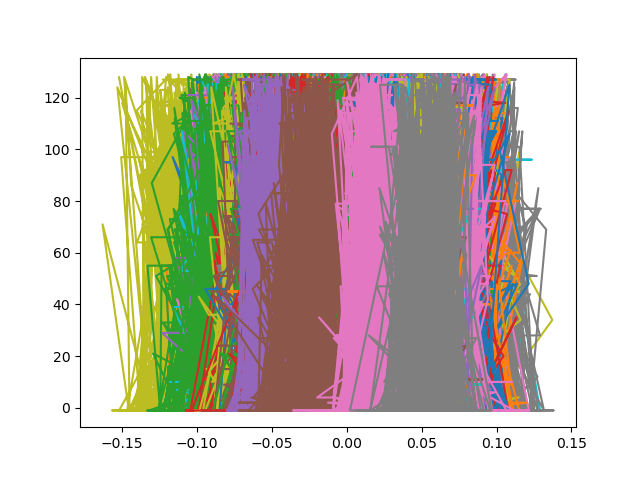

In [56]:
plt.plot(X, hdb.labels_);

Although no dimension reduction was done for calculating the clusters, we can still use it to visualise the data points in 2 dimensions. There are various dimensionality reduction techniques. Here are two popular ones:
- **T-SNE** is better at preserving clusters.
- **PCA** is better at preserving distances and therefore the size of differences. 

Because they necessarily result in a loss of data, it's important to check that the chosen technique is helping in the particular context. Let's compare them on the data:

Some visualisation techniques automatically perform this feature/dimension reduction, but for now I will calculate them separately and append them to the sample dataset. Now a sample record looks like this:

In [57]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components = 2).fit_transform(np.asarray(X))
df_multi_roud_w_embed['tsne'] = X_tsne.tolist()

from sklearn.decomposition import PCA
X_pca = PCA(n_components = 2).fit_transform(np.asarray(X))
df_multi_roud_w_embed['pca'] = X_pca.tolist()

In [58]:
display(df_multi_roud_w_embed.iloc[10])

index                                                                   114
key_name                                      Blue-Tail Fly, The [Laws I19]
name                                                         Jim Crack Corn
version_in_key                                                            A
bi_file                                                                LI19
dt_file                                                            BLUETAIL
roud                                                                   1274
lyrics                    When I was young I us'd to wait, On Massa and ...
roud_count                                                              3.0
lyric_embed_instructor    [-0.018739486, -0.010365271, -0.058310274, 0.0...
tsne                               [4.3185577392578125, -49.74964141845703]
pca                              [0.0858643501996994, -0.07742226868867874]
Name: 110, dtype: object

##### T-SNE:

In [59]:
#plotting function from https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html
def clusterplot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

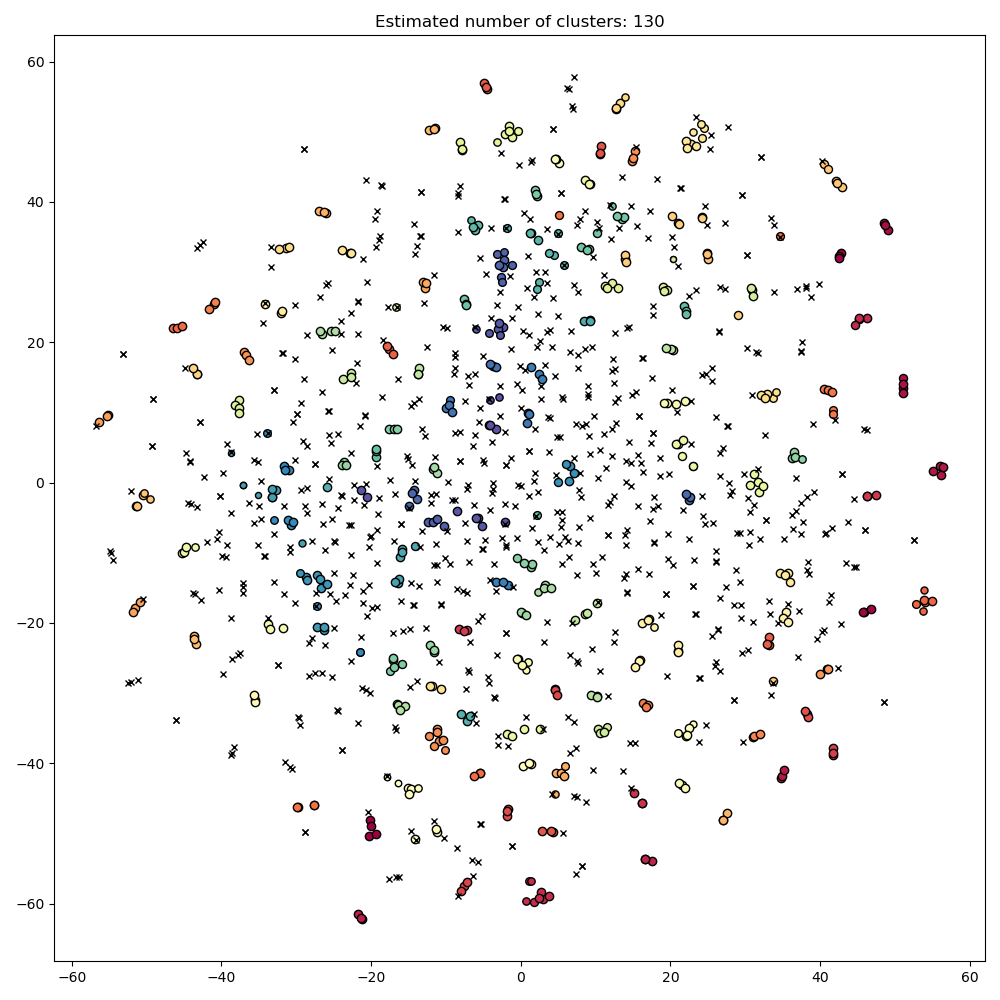

In [60]:
clusterplot(X_tsne, hdb.labels_, hdb.probabilities_)

##### PCA:

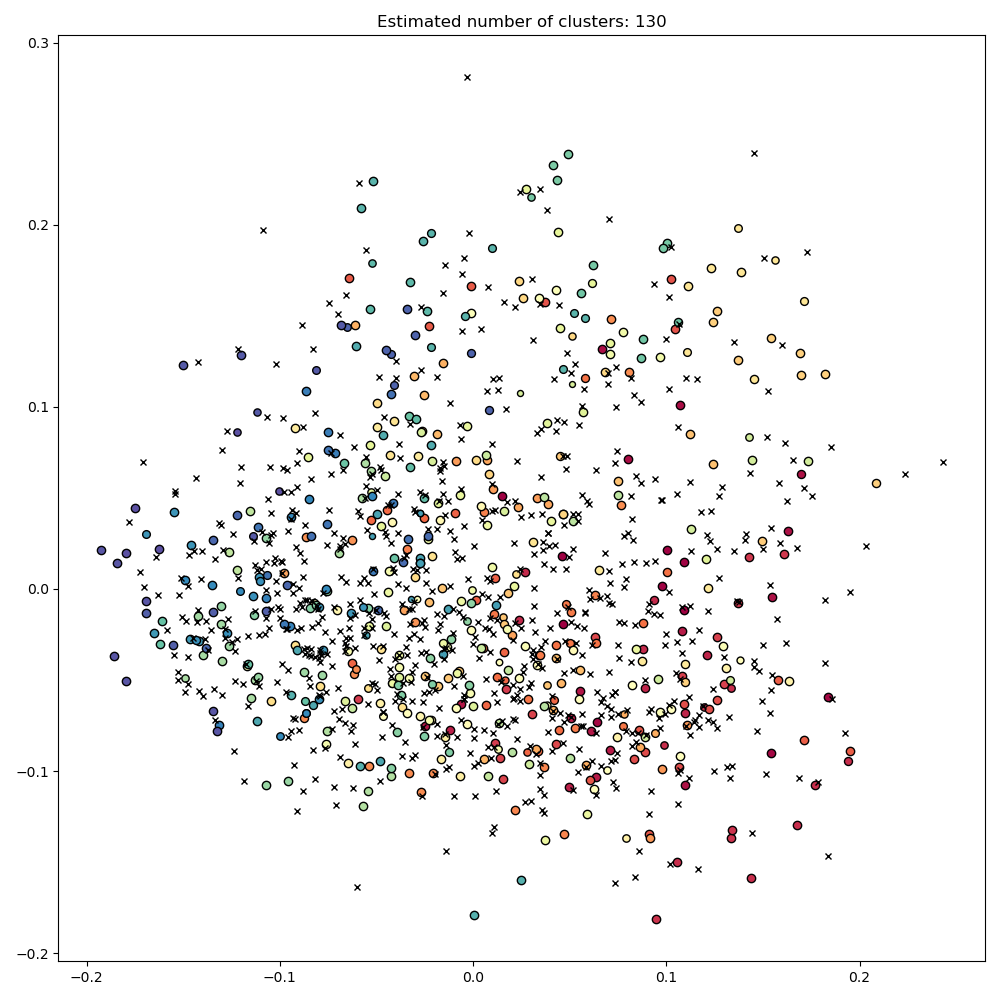

In [61]:
clusterplot(X_pca, hdb.labels_, hdb.probabilities_)

T-SNE seems to produce the best results, but I need to inspect the data to be sure that the clusters reflect the lyrics.

### Compare clusters to Roud numbers

Here are the counts of unique song names and Roud numbers per cluster label. Some clusters have multiple Roud numbers in them:

In [62]:
df_multi_roud_w_embed_label = df_multi_roud_w_embed.copy()
df_multi_roud_w_embed_label = df_multi_roud_w_embed_label.reset_index().join(df_cluster_labels)
df_multi_roud_w_embed_label.sort_values(by=[0])[['name', 'roud', 'probabilities', 0]].groupby([0]).nunique().sort_values(by='roud')

name  roud  probabilities
0                              
 64      1     1              3
 78      3     1              1
 77      6     1              4
 76      5     1              2
 120     3     1              1
...    ...   ...            ...
 116     6     4              3
 107    10     5              6
 128     7     5              4
 112     7     5              4
-1     738   241              1

[131 rows x 3 columns]

Let's graph only the songs that got a valid label (not -1):

In [63]:
clusters_v_roud = df_multi_roud_w_embed_label.sort_values(by=[0])[['name', 'roud', 'probabilities', 0]][df_multi_roud_w_embed_label[0] >=0]
clusters_v_roud = clusters_v_roud.rename(columns={0: 'cluster_label'}).sort_values(by='roud')

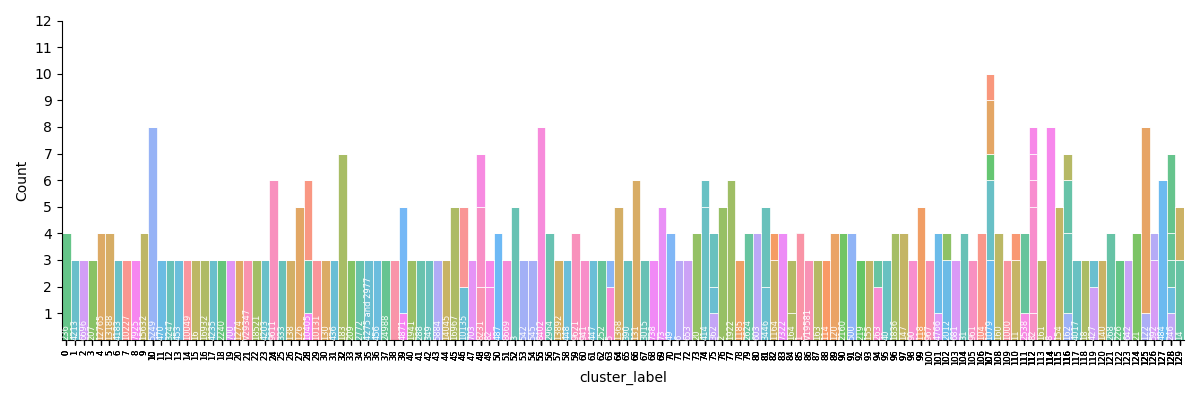

In [64]:
#TODO: add roud label fixed and song label hover
%matplotlib ipympl
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(fig)

hist_plot = sns.histplot(
    clusters_v_roud,
    x='cluster_label', binwidth=1,
    hue='roud',
    discrete=True,
    multiple="stack",
    edgecolor="white",
    linewidth=.5
)
ax.set_xticks(clusters_v_roud.cluster_label)
ax.set_yticks(np.arange(1, 13, step=1))
ax.margins(x=0)
plt.xticks(fontsize = 6, rotation=90)

# TODO: Add labels to the 'hue' patches insead of bars 
for bar in ax.containers[0]:  
    height = bar.get_height()
    width = bar.get_width()
    x_pos = bar.get_x() + width / 2
    y_pos = height
    label = clusters_v_roud.loc[clusters_v_roud['cluster_label'] == x_pos, 'roud'].values[0]
    
    ax.text(x_pos, y_pos, label, ha='center', va='bottom', fontsize=6, color='white', rotation='vertical')

ax.get_legend().set_visible(False)

plt.tight_layout()

Most cluster labels, however, were assigned to exactly three songs (our minimum set for both cluster size and minimum Roud sample size) all of the same Roud number. That suggests at least a partially successful clustering. 

Let's look at one of the 24 clusters containing songs with differing Roud numbers and see if it's clear why this happened:

In [65]:
roud_per_cluster = clusters_v_roud.groupby('cluster_label').nunique()
multi_roud_per_cluster = roud_per_cluster[roud_per_cluster.roud >1]
multi_roud_per_cluster.sort_values(by='roud', ascending=False)

name  roud  probabilities
cluster_label                           
128               7     5              4
112               7     5              4
107              10     5              6
116               6     4              3
28                6     3              4
48                6     3              4
75                4     3              2
102               4     2              2
126               4     2              2
125               8     2              6
119               3     2              1
111               4     2              2
110               4     2              2
101               4     2              2
39                2     2              3
94                3     2              1
84                3     2              1
82                4     2              2
81                4     2              3
74                5     2              3
63                3     2              1
49                2     2              1
46                5     2              2
129               5     2              2

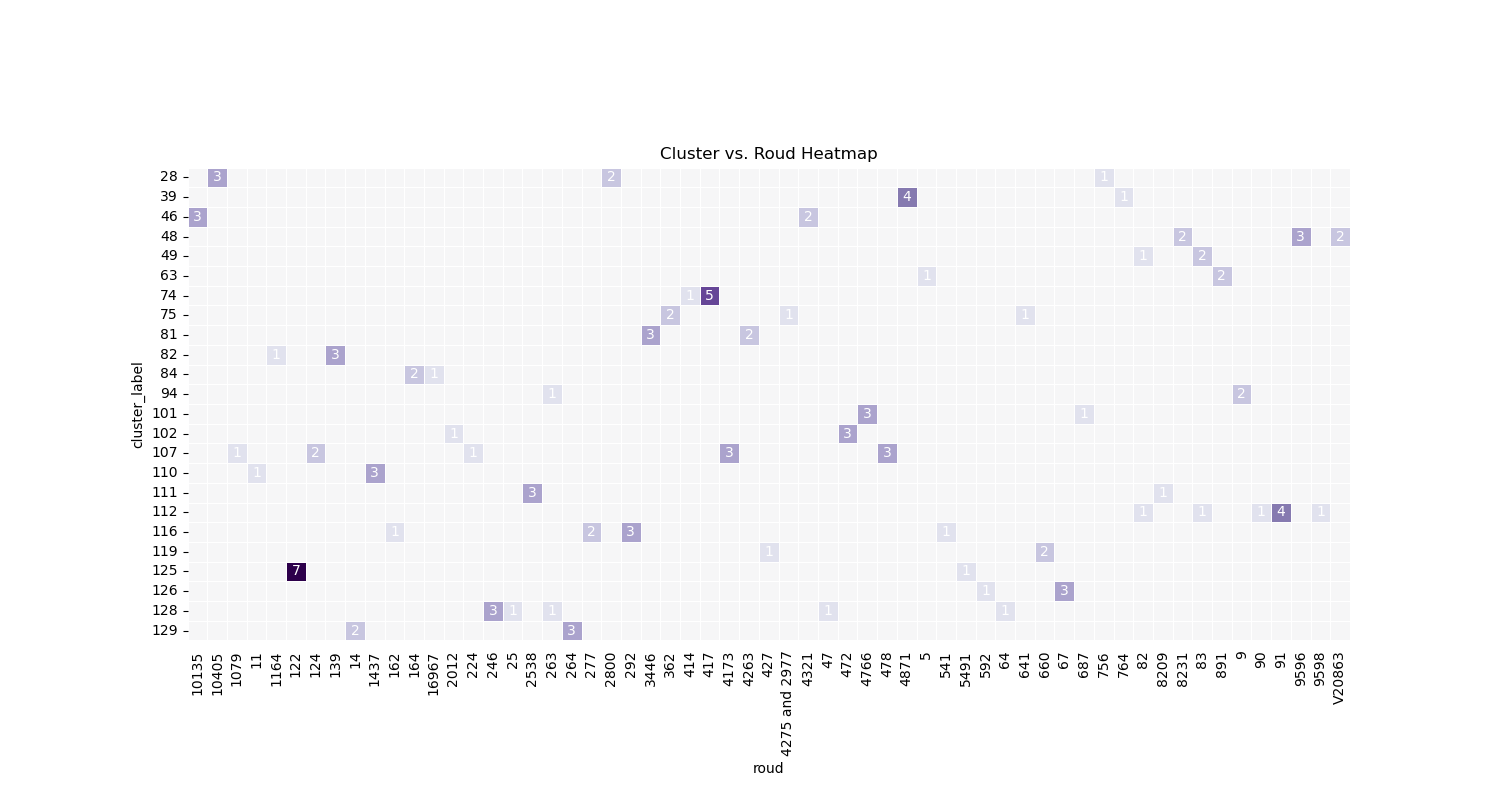

In [66]:
clusters_v_roud_multi = clusters_v_roud[clusters_v_roud['cluster_label'].isin(multi_roud_per_cluster.reset_index()['cluster_label'])]
clusters_v_roud_multi #.reset_index(inplace=True)

plt.figure(figsize=(15, 8)) 
cross_tab = pd.crosstab(clusters_v_roud_multi['cluster_label'], clusters_v_roud_multi['roud'])
sns.heatmap(cross_tab, fmt="d", cmap='PuOr', center=0, cbar=False, linewidths=0.5, linecolor='white')

# annotate only non-zero values
for i in range(cross_tab.shape[0]):
    for j in range(cross_tab.shape[1]):
        value = cross_tab.iloc[i, j]
        if value != 0:
            plt.text(j + 0.5, i + 0.5, str(value), va='center', ha='center', color='white', fontsize=10)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tick_params(which='both', bottom=False, top=False)

plt.title('Cluster vs. Roud Heatmap')
plt.gca().set_aspect('equal')

plt.show()


Cluster 107 is particularly diffuse. Upon an initial inspection of these songs, they are all immediately recognisable as nautical. This is a good demonstration of the semantic embedding.

In [67]:
df_107 = df_multi_roud_w_embed_label[df_multi_roud_w_embed_label[0] == 107]
df_107[['key_name','name', 'roud', 'lyrics', 0, 'probabilities']].sort_values(by='probabilities', ascending=False)

key_name  \
30    Captain Glen/The New York Trader (The Guilty S...   
856                                                 NaN   
1241                                                NaN   
1119                                                NaN   
31             Captain Ward and the Rainbow [Child 287]   
372                                                 NaN   
833                                                 NaN   
835                                                 NaN   
1031                                                NaN   
1117                                                NaN   

                                              name  roud  \
30    Captain Glen's Unhappy Voyage to New Barbary   478   
856                            The New York Trader   478   
1241                                  William Glen   478   
1119                                 The Titanic 6  4173   
31        Captain Ward and the Rainbow [Child 287]   224   
372                                    The Calabar  1079   
833                                    The Mermaid   124   
835                                The Mermaid (4)   124   
1031                        Sinking of the Titanic  4173   
1117                                   Titanic (7)  4173   

                                                 lyrics    0  probabilities  
30    There was a ship, and a ship of fame, Launched...  107       1.000000  
856   To a New York trader I dld belong.\nShe was we...  107       1.000000  
1241  There was a ship and a ship of fame .\nLaunch'...  107       1.000000  
1119  You feeling hearted Christians, oh, listen to ...  107       0.945796  
31    Strike up, ye lust gallants, With music beat o...  107       0.928249  
372   Come all ye dry-land sailors and listen to my ...  107       0.921126  
833   Twas Friday morn when we set sail\nAnd we were...  107       0.916683  
835   As I sailed from Galway in service to the Quee...  107       0.916683  
1031  It was on the 10th of April on a sunny afterno...  107       0.914898  
1117  It was midnight on the sea\nBand playing, "nea...  107       0.914898

All the lyrics with 100% probability or close are variations on *Captain Glen/The New York Trader*, Roud #478.

Interestingly, the probabilities mainly align with the Roud numbers of the other songs, except for *The Titanic (6)* which is separated from other versions. According to the [Clare County Library](https://www.clarelibrary.ie/eolas/coclare/songs/cmc/the_titanic_msflanagan.htm), this version in fact has Roud #6662 and not #4173. The source, DT, has no Roud number, which indicates the number was misapplied by one of my algorithms, probably the filename allocation.


It could be possible that 'leaf' cluster selection might give better results given the many small clusters. Visualising the clustering tree or looking at the probabilities could give more insights, but the `sklearn` version of HDBSCAN doesn't support this feature, so I will continue with the original version of the model.

## Method 2: Clustering using original `hdbscan.HDBSACAN`

The version of HDBSCAN currently officially implemented by `sklearn` also does not have the `prediction_data=True` parameter which allows us to do soft clustering. Instead I'll load the standalone 'contributions' version from which it is derived (from [Github](https://github.com/scikit-learn-contrib/hdbscan.git) - there is a [bug](https://github.com/scikit-learn-contrib/hdbscan/releases/tag/0.8.33) in the current main one). This time I will fit the model with the extra parameters available.

In [68]:
import hdbscan
hdb2 = hdbscan.HDBSCAN(prediction_data=True, min_cluster_size=3, min_samples=2, gen_min_span_tree=True)
data = np.array(X)
hdb2.fit(data)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=3, min_samples=2,
        prediction_data=True)

Using `min_samples=2` I could achieve a similar number of clusters to the `sklearn` version, at 129. Using any higher value resulted three or fewer clusters.

In [69]:
hdb2.labels_.max()

129

In [70]:
hdb2.probabilities_

array([1., 0., 1., ..., 0., 0., 1.])

118 samples have probabilities of less than 1.

In [81]:
df_cluster_labels_2 = pd.DataFrame()
df_cluster_labels_2['cluster_label'] = hdb2.labels_
df_cluster_labels_2['probability'] = hdb2.probabilities_
df_cluster_labels_2[df_cluster_labels_2.probability.between(0,1, inclusive=False)]

cluster_label  probability
15               39     0.834146
31              107     0.928249
50               66     0.737086
54              125     0.924799
56               64     0.906728
...             ...          ...
1190             74     0.950982
1213            128     0.988382
1249             28     0.914149
1250             28     0.936858
1253            116     0.879220

[117 rows x 2 columns]

### Cluster Analysis

#### Dendrogram and distance metrics

Here is the tree of splits from the new clusterer. It has a potentially unusual left-branching shape, which may indicate that there could be a more efficient way to split the data, but it's not yet clear how.

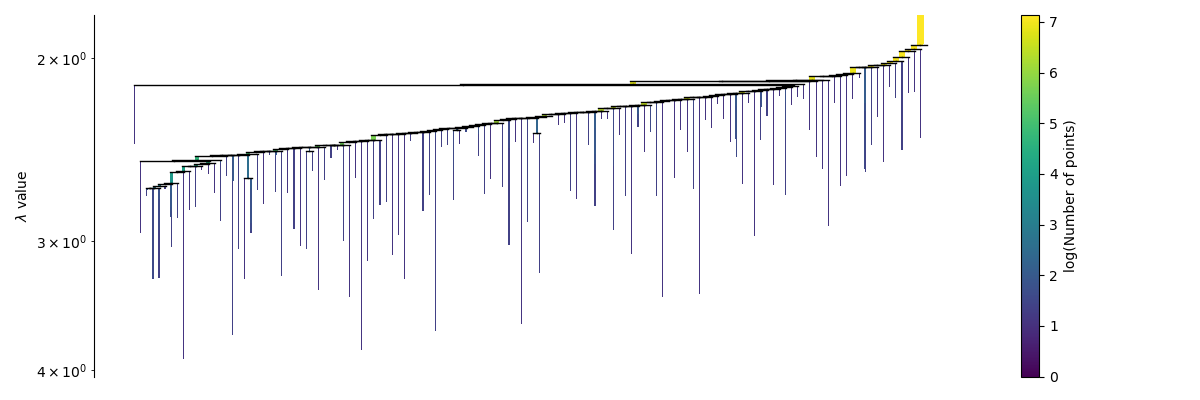

In [83]:
#%matplotlib inline
plt.figure(figsize=(12,4))
hdb2.condensed_tree_.plot(cmap="viridis", log_size=True)
plt.yscale("log")
plt.tight_layout()
plt.show()


##### Distance metrics

Distance metrics affect the 'closeness' of points, and the choice of metric might therefore depend on what kind of closeness should be measured in a given task. Let's see if different distance metrics make a difference to how splits are discovered by the clustering model (`min_cluster_size=3, min_samples=2`).

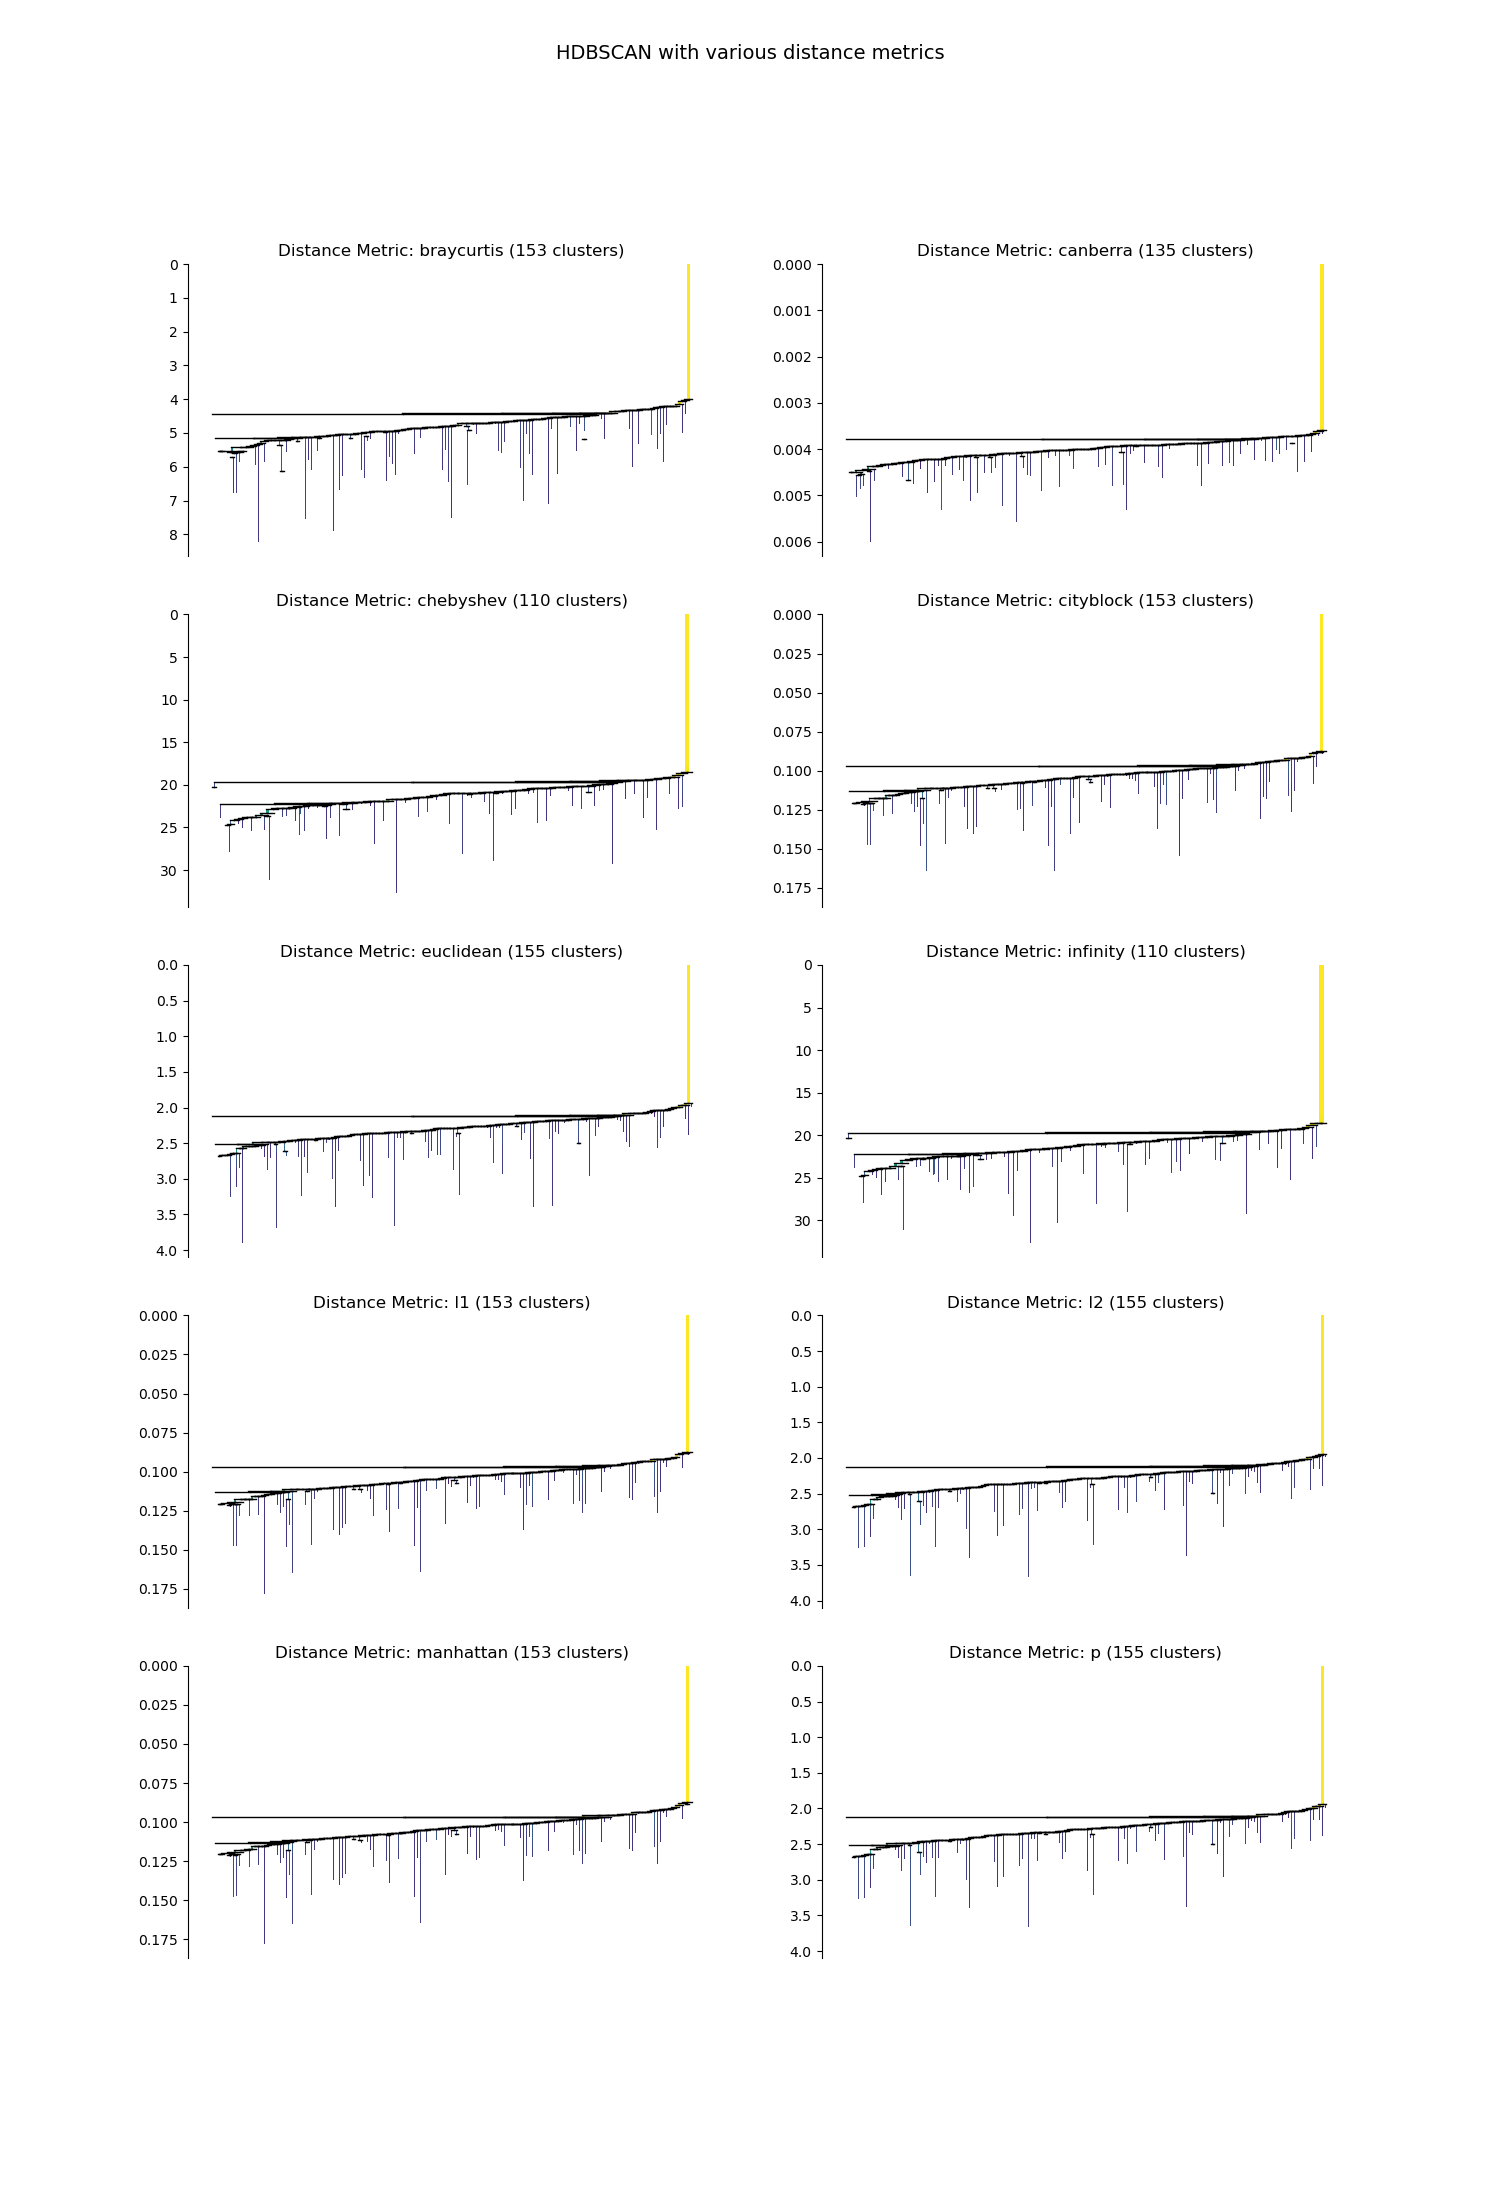

In [84]:
data = np.array(X)
distance_metrics = ('braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'euclidean',
 'infinity',
 'l1',
 'l2',
 'manhattan',
 'p'
)

fig, axes = plt.subplots(5, 2, figsize=(15, 22))
fig.suptitle('HDBSCAN with various distance metrics', fontsize=14)

for ax, metric in zip(axes.ravel(), distance_metrics):
    # clustering
    clusterer = hdbscan.HDBSCAN(metric=metric, min_cluster_size=2, min_samples=2) #, min_samples=2
    clusterer.fit(data)
    # plot
    clusterer.condensed_tree_.plot(cmap="viridis", colorbar=False, log_size=True, axis=ax) #log_size=True, 
    num_clusters = len(np.unique(clusterer.labels_))
    ax.set_title(f"Distance Metric: {metric} ({num_clusters} clusters)")
    #ax.set_yscale("log")
    ax.set_ylabel('')

plt.show()


#### Soft clustering membership probabilities (multiple clusters per point)

According to the [docs](https://hdbscan.readthedocs.io/en/latest/api.html#hdbscan.prediction.membership_vector), the probability that point `i` is a member of cluster `j` is in `membership_vectors[i, j]`. I extracted the first, second and third choices of clusters for each data point and combined them with the hard clustering results.

In [85]:
membership_vectors = hdbscan.all_points_membership_vectors(hdb2)

mem = [] #temp results storage
for i, j in enumerate(membership_vectors):
    # Get the original cluster label and probability
    soft_cluster0 = j.argmax()
    soft_probability = j[soft_cluster0]
    
    # Sort the probabilities in descending order and get the indices
    sorted_indices = j.argsort()[::-1]
    
    # Get the top two next highest probabilities
    soft_cluster1 = sorted_indices[1]
    soft_probability1 = j[soft_cluster1]
    
    soft_cluster2 = sorted_indices[2]
    soft_probability2 = j[soft_cluster2]
    
    # Append the data for the current datapoint
    mem.append([i, soft_cluster0, soft_probability, soft_cluster1, soft_probability1, soft_cluster2, soft_probability2])

# Create a dataframe from the collected data
columns = ['datapoint', 'soft_cluster_0', 'soft_probability_0', 'soft_cluster_1', 'soft_probability_1', 'soft_cluster_2', 'soft_probability_2']
df_soft_cluster = pd.DataFrame(mem, columns=columns)
df_soft_merged = df_cluster_labels_2.join(df_soft_cluster)

In [86]:
df_soft_cluster_data = df_multi_roud_w_embed_label[['name', 'roud', 'roud_count', 'lyrics']].join(df_soft_merged).drop(['datapoint'], axis=1)
df_soft_cluster_data

name    roud  roud_count  \
0                             The Song of Agincourt  V29347         3.0   
1                         O Falmouth Is a Fine Town     269         7.0   
2     Atisket, Atasket (I Sent a Letter to My Love)   13188         4.0   
3     Atisket, Atasket (I Sent a Letter to My Love)   13188         4.0   
4     Atisket, Atasket (I Sent a Letter to My Love)   13188         4.0   
...                                             ...     ...         ...   
1254                                  Young Barbour      64         4.0   
1255                                  Young Hunting      47         5.0   
1256                                Young Hunting 2      47         5.0   
1257                                    Young Redin      47         5.0   
1258             Young Sailor Cut Down in His Prime       2        23.0   

                                                 lyrics  cluster_label  \
0     Deo gracias anglia, Redde pro victoria, 1 Owre...             21   
1     Text supplied by Don Duncan. Reportedly writte...             -1   
2     I wrote a letter to my love; I carried water i...              5   
3     And the night before; if he does again to-nigh...              5   
4     A green leather basket; I wrote a letter to my...              5   
...                                                 ...            ...   
1254  'Twas of a lady in the west counteree,\nShe wa...            128   
1255  It happened on one evening late,\nAs the maid ...             -1   
1256  A lady stood in her bower door,\nIn her bower ...             -1   
1257  Young Redin's til the hunting gane\nWi' therty...             -1   
1258  One day as I strolled down by the Royal Albion...             76   

      probability  soft_cluster_0  soft_probability_0  soft_cluster_1  \
0             1.0              21            1.000000              34   
1             0.0             119            0.008932             101   
2             1.0               5            1.000000              64   
3             1.0               5            1.000000              83   
4             1.0               5            1.000000              64   
...           ...             ...                 ...             ...   
1254          1.0             128            1.000000             126   
1255          0.0             128            0.009523             124   
1256          0.0             124            0.009534             126   
1257          0.0             117            0.008927             128   
1258          1.0              76            1.000000             122   

      soft_probability_1  soft_cluster_2  soft_probability_2  
0          1.330760e-306             117       1.321288e-306  
1           8.849026e-03             127        8.712979e-03  
2          1.295204e-306             103       1.283226e-306  
3          1.389333e-306              88       1.354348e-306  
4          1.418865e-306              86       1.411175e-306  
...                  ...             ...                 ...  
1254       1.860417e-306             124       1.826845e-306  
1255        9.239774e-03             126        8.754074e-03  
1256        9.189294e-03             129        9.078690e-03  
1257        8.532307e-03              95        8.371151e-03  
1258       1.641345e-306             127       1.570397e-306  

[1259 rows x 12 columns]

Let's return to cluster 107. I now also include points that would have been considered 107 if they had been clustered, but were considered too noisy. Note that the cluster membership probabilities work differently in soft format. 

In [88]:
df_soft_cluster_data[df_soft_cluster_data.soft_cluster_0==107].sort_values(by='probability', ascending=False)

name            roud  \
30    Captain Glen's Unhappy Voyage to New Barbary             478   
856                            The New York Trader             478   
1241                                  William Glen             478   
1119                                 The Titanic 6            4173   
31        Captain Ward and the Rainbow [Child 287]             224   
372                                    The Calabar            1079   
206                      Andrew Ross (Andrew Rose)             623   
252                             The Bayou Sara (2)  10010 and 4139   
305              Blow Ye Winds in the Morning (Ii)            2012   
383                              Christofo Columbo            4843   
418                       The Cruel Ship's Captain             623   
628           The House Down in Carne (Nuke Power)              14   
820                           The Manchester Canal            1079   
205                                    Andrew Rose             623   
1037                             Sir Patrick Spens              41   
1041                                Skye Boat Song            3772   
384                            Christopher Columbo            4843   

      roud_count                                             lyrics  \
30           3.0  There was a ship, and a ship of fame, Launched...   
856          3.0  To a New York trader I dld belong.\nShe was we...   
1241         3.0  There was a ship and a ship of fame .\nLaunch'...   
1119         5.0  You feeling hearted Christians, oh, listen to ...   
31           3.0  Strike up, ye lust gallants, With music beat o...   
372          3.0  Come all ye dry-land sailors and listen to my ...   
206          3.0  Come all you seamen and give attention\nAnd li...   
252          3.0  Sol Matting he lied a-sleeping,\nPoor boy was ...   
305          3.0  It's advertised in Boston, New York and Buffal...   
383          3.0  I'll sing to you about a man whose name you'll...   
418          3.0  A boy to me was bound apprenticed\nBecause his...   
628          4.0  Well me name is Nuke Power, a terror am I,\nI ...   
820          3.0  O the S.S. Irwell left this port the stormy se...   
205          3.0  Andrew Rose, the British sailor\nNow to you hi...   
1037         3.0  The King sits in Dumferlane toon\nA-drinkin' a...   
1041         3.0  Speed bonnie boat, like a bird on the wing,\nO...   
384          3.0  In fourteen hundred and ninety-two\nA man whos...   

      cluster_label  probability  soft_cluster_0  soft_probability_0  \
30              107     1.000000             107            1.000000   
856             107     1.000000             107            1.000000   
1241            107     1.000000             107            1.000000   
1119            107     0.945796             107            0.010022   
31              107     0.928249             107            0.009776   
372             107     0.921126             107            0.009737   
206              -1     0.000000             107            0.009425   
252              -1     0.000000             107            0.008255   
305              -1     0.000000             107            0.007852   
383              -1     0.000000             107            0.008912   
418              -1     0.000000             107            0.008970   
628              -1     0.000000             107            0.008166   
820              -1     0.000000             107            0.008826   
205              -1     0.000000             107            0.007011   
1037             -1     0.000000             107            0.009463   
1041             -1     0.000000             107            0.008053   
384              -1     0.000000             107            0.008030   

      soft_cluster_1  soft_probability_1  soft_cluster_2  soft_probability_2  
30               106       1.711467e-306             100       1.700073e-306  
856              125       1.708829e-306           

### Visualisation

Now I want to view my embeddings and clusters in a 2D or 3D space. There are specialised tools for this which combine the steps of feature reduction and visualisation, but I have already calculated t-SNE in two dimensions so I can use this for plotting in 2D directly. Using a slightly more advanced plotter, `plotly.express`, will allow me to inspect the data points and clusters better.

In [104]:
df_multi_roud_w_embed_label = df_multi_roud_w_embed_label.rename(columns={0: 'cluster_label', 'probabilities': 'probability'}).drop('index', axis=1)
#df_multi_roud_w_embed_label.to_pickle('multi_roud_w_embed_label.p')

In [251]:
df_plotly = df_multi_roud_w_embed_label.sort_values(by='cluster_label')
df_plotly['cluster_label'] = df_plotly['cluster_label'].astype(str)


In [253]:
# make non-cluster -1 grey
color_map = {'-1': 'lightgray'}  # nb key is a string
# colours for other cluster labels
num_clusters = df_plotly['cluster_label'].nunique()
other_colors = px.colors.qualitative.Set1[:num_clusters - 1]
color_map.update(dict(zip(map(str, range(num_clusters - 1)), other_colors)))

fig = px.scatter(df_plotly,
                 x=df_plotly['tsne'].str.get(0),
                 y=df_plotly['tsne'].str.get(1),
                 color='cluster_label',
                 color_discrete_map=color_map,
                 hover_name='name',
                 hover_data={'roud': True},
                 labels={'tsne': 't-SNE', 'cluster_label': 'Cluster Label'},
                 title='t-SNE Visualisation with Cluster Labels'
                )

fig.update_layout(xaxis_title='t-SNE X', yaxis_title='t-SNE Y')

fig.update_xaxes(scaleanchor="y", scaleratio=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_layout(width=1500, height=1100)

fig.show()


Here we can observe that by using t-SNE we can see clusters that `HDBSCAN` could not. Let's try just feeding the t-SNE values of the vectors directly into the model.

## Method 3: Clustering on T-SNE instead

In [181]:
hdb_tsne = hdbscan.HDBSCAN(prediction_data=True, min_cluster_size=3, min_samples=2, gen_min_span_tree=True)
data = df_multi_roud_w_embed_label.tsne.to_list()
hdb_tsne.fit(data)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=3, min_samples=2,
        prediction_data=True)

In [ ]:
#todo: did i delete a df col assignment here?

In [242]:
df_plotly

level_0       key_name                              name version_in_key  \
158      1056  Teasing Songs                     Teasing Songs              A   
468      3373            NaN                 Down the River(2)            NaN   
819      6177            NaN            Man of Constant Sorrow            NaN   
813      6082            NaN             Lowlands of Holland 6            NaN   
805      6074            NaN                          Lowlands            NaN   
...       ...            ...                               ...            ...   
60        400   Green Gravel                      Green Gravel              F   
624      4695            NaN          The Holland Handkerchief            NaN   
1212     9506            NaN                     Lady Margaret            NaN   
1217     9545            NaN             Sweet William's Ghost            NaN   
870      6861            NaN  Oh, Who Is at My Bedroom Window?            NaN   

     bi_file   dt_file             roud  \
158    EM256  SWTVILT2  10232 and 10404   
468     R592  DOWNRIV2             7677   
819   CSW113  CONSTSOR              499   
813     R083  LOWHOLL6              484   
805     C286  VANTYGL9              122   
...      ...       ...              ...   
60      R532  GRNGRAVL             1368   
624      NaN  SUFFMRC4              246   
1212    C077  WILIGHO2               50   
1217    C077  WILIGHOS               50   
870     LM04  SILVDAG3  22620 and 22621   

                                                 lyrics  roud_count  \
158   My father's a lavatory cleaner, He works all t...         3.0   
468   Oh! the river is up and the channel is deep,\n...         3.0   
819   I am a man of constant sorrow\nI've seen troub...         3.0   
813   My love has built a bonnie ship and set her on...        12.0   
805   A boy he had an auger\nThat bored two holes at...        11.0   
...                                                 ...         ...   
60    similar to the above, in which the King sends ...         7.0   
624   There was a lord lived in this town;\nHis prai...         4.0   
1212  1.Lady Margaret sitting in her own lone home,\...         3.0   
1217  There came a ghost to Margaret's door\nWith ma...         3.0   
870   Oh, who is at my bedroom window,\nDisturbing m...         5.0   

                                 lyric_embed_instructor  \
158   [-0.024734592, 0.008803896, -0.017447433, 0.00...   
468   [-0.060044736, -0.007352145, -0.031162467, 0.0...   
819   [-0.06407344, -0.0005744899, -0.064674266, 0.0...   
813   [-0.042404126, -0.022763843, -0.025479745, 0.0...   
805   [-0.035781313, -0.0020581644, -0.038625307, 0....   
...                                                 ...   
60    [-0.049485464, 0.011227211, -0.017543187, 0.04...   
624   [-0.041949566, -0.011385148, -0.028533552, 0.0...   
1212  [-0.0379538, 0.0055425367, -0.033770416, 0.040...   
1217  [-0.044762462, 0.0029134688, -0.043984536, 0.0...   
870   [-0.028516868, -0.018946797, -0.026683377, 0.0...   

                                            tsne  \
158   [-13.657355308532715, -14.710352897644043]   
468     [30.202899932861328, 32.370948791503906]   
819     [18.663698196411133, 0.9300674200057983]   
813     [-6.164587020874023, 22.162565231323242]   
805    [-5.4679741859436035, 31.982099533081055]   
...                                          ...   
60       [-6.266772747039795, -3.24650239944458]   
624      [-5.777307987213135, -5.01576566696167]   
1212    [-5.130154609680176, -9.474664688110352]   
1217      [-5.1066575050354, -9.418922424316406]   
870    [-4.7569098472595215, -8.129509925842285]   

                                               pca  cluster_label  \
158    [0.11169321089982986, -0.05945173650979996]             -1   
468    [0.11235740780830383, 0.059009138494729996]             -1   
819   [0.11235469579696655, -0.009118037298321724]             -1   
813     [-0.1421692967414856, 0.12485475838184357]   

In [369]:

df_plotly['cluster_tsne'] = df_plotly['cluster_tsne'].astype(str)

In [370]:
#TODO: make clusters int and discrete

# make non-cluster -1 grey
color_map = {'-1': 'lightgray'}  # nb key is a string
# colours for other cluster labels
num_clusters = df_plotly['cluster_label'].nunique()
other_colors = px.colors.qualitative.Set1[:num_clusters - 1]
color_map.update(dict(zip(map(str, range(num_clusters - 1)), other_colors)))

# Calculate localized centroids for 'roud' annotations
def calculate_annotations():
    unique_roud_values = df_plotly['roud'].unique()
    annotations = []

    for roud_value in unique_roud_values:
        roud_clusters = df_plotly[df_plotly['roud'] == roud_value]['cluster_tsne'].unique()
        
        for cluster_label in roud_clusters:
            roud_points = df_plotly[(df_plotly['roud'] == roud_value) & (df_plotly['cluster_tsne'] == cluster_label)]
            if len(roud_points) > 0:
                centroid_x = roud_points['tsne'].str.get(0).mean()
                centroid_y = roud_points['tsne'].str.get(1).mean()
                if len(roud_points) > 1:
                    annotations.append(dict(x=centroid_x, y=centroid_y,
                                            xref="x", yref="y",
                                            text=roud_value,
                                            showarrow=True,
                                            arrowhead=2,
                                            ax=0,
                                            ay=-25))
                else:
                    annotations.append(dict(x=centroid_x, y=centroid_y,
                                            xref="x", yref="y",
                                            text=roud_value,
                                            showarrow=False,
                                            ax=0,
                                            ay=0))
    return annotations

annotations = calculate_annotations()

# Create the scatter plot
fig = px.scatter(df_plotly,
                 x=df_plotly['tsne'].str.get(0),
                 y=df_plotly['tsne'].str.get(1),
                 color='cluster_tsne',
                 color_discrete_map=color_map,
                 hover_name='name',
                 hover_data={'roud': True},
                 labels={'cluster_tsne': 'Cluster Label'},
                 title='t-SNE reduced HDBSCAN Clustering'
                )

# Add buttons to toggle annotations
button_on = dict(label='Annotations On',
                 method='relayout',
                 args=[{'annotations': annotations}])

button_off = dict(label='Annotations Off',
                  method='relayout',
                  args=[{'annotations': []}])

fig.update_layout(updatemenus=[
    dict(type='buttons', showactive=True, buttons=[button_on, button_off])
])

fig.update_layout(xaxis_title='t-SNE X', yaxis_title='t-SNE Y')
fig.update_xaxes(scaleanchor="y", scaleratio=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_layout(width=1400, height=1100)

fig.show()


In [254]:
df_multi_roud_w_embed_label['probability_tsne'] = hdb_tsne.probabilities_

Clustering on the dimension-reduced data finds more (230) and larger groups, and treats less data with noise. It also, however, increases potential false matches: 122 clusters now have mixed Roud numbers, compared to 24.

In [185]:
hdb_tsne.labels_.max()

230

In [267]:
df_multi_roud_w_embed_label.sort_values(by='cluster_tsne')\
    [['cluster_tsne', 'name', 'roud']]\
    .groupby('cluster_tsne')\
    .nunique()\
    .loc[lambda x: x['roud'] > 1]\
    .sort_values(by='roud', ascending=False)

name  roud
cluster_tsne            
-1             168    96
 219            15    10
 172            24     8
 131             9     7
 212            11     7
...            ...   ...
 109             5     2
 108             4     2
 105             3     2
 103             4     2
 230             3     2

[122 rows x 2 columns]

The T-SNE cluster 219 has the largest selection of Roud numbers. When we examine it we see a collection of Scotland-related songs. This was also visible in a mixed-Roud cluster in Method 1 which contained some Scots and Scottish dialect words (more than here), leading me to suspect that these are limitations in using these embeddings on some varieties of English. Note: the texts also contain archaic language but the model seems to handle this better.

In [249]:
df_multi_roud_w_embed_label[df_multi_roud_w_embed_label['cluster_tsne'] == 219][['name', 'lyrics','roud', 'roud_count', 'cluster_tsne', 'probability_tsne']].sort_values(by='probability_tsne', ascending=False)

name  \
485          Fair Flower of Northumberland   
486        Fair Flower of Northumberland 2   
613          The Heiress of Northumberland   
1213                  The Lord of Scotland   
788                            Lord Banner   
85                               Lochinvar   
725           Katherine Jaffry (Lochnagar)   
84           Katharine Jaffray [Child 221]   
599         The Grey Silkie of Sule Skerry   
748           Lady Odivere (Grey Silkie 3)   
729                         Kellyburnbraes   
112            Mother, Mother, Make My Bed   
737   Knight and the Shepherd's Daughter 3   
322                           Bonnie Annie   
373         Captain Wedderburn's Courtship   

                                                 lyrics roud  roud_count  \
485   The provost's aye daughter was making her lane...   25         3.0   
486   It was a knight in Scotland born,\nFollow, my ...   25         3.0   
613   "Why, fair maid, have pity on me,"\nWaly's my ...   25         3.0   
1213  The Lord of Scotland, he is come home\nUnto hi...   47         5.0   
788   Four and twenty ladies,\nThey being at a ball,...   52         4.0   
85    Sir Walter Scott's adaption of the above. He s...   93         4.0   
725   Lochnagar cam frae the west\nInto the low coun...   93         4.0   
84    1 There livd a lass in yonder dale, And doun i...   93         4.0   
599   In Norwa land, there lived a maid\nBaloo, my b...  197         3.0   
748   In Norowa a lady bade\nA bonny lass in muckle ...  197         3.0   
729   There lived a carl in Kellyburnbraes,\nHey and...  160         7.0   
112   She called to her little page boy, Who was her...   45         4.0   
737   Earl Richard, once upon a day,\nAnd all his va...   67         5.0   
322   There was a rich merchant wha lived in Strathd...  172         3.0   
373   The Laird o' Roslin's daughter\nWalked through...   36         3.0   

      cluster_tsne  probability_tsne  
485            219          1.000000  
486            219          1.000000  
613            219          1.000000  
1213           219          1.000000  
788            219          0.984013  
85             219          0.925318  
725            219          0.925318  
84             219          0.880717  
599            219          0.879330  
748            219          0.879330  
729            219          0.725164  
112            219          0.725115  
737            219          0.722462  
322            219          0.702716  
373            219          0.702716

Interestingly, the model is 100% certain that *The Lord of Scotland* belongs with the songs at Roud #25. Although officially it belongs to Roud #47, it was collected in the 1940s from George Edwards of Vermont, USA. [R. Matteson](http://www.bluegrassmessengers.com/lord-of-scotland--edwards-vt-c1941-cazden.aspx) remarks, "It's clear to me that some of his ballads are recreations from print sources. [...]  It's hard to tell what is traditional."

Although the model could be bringing new insights, it most likely needs tuning first. Let's see if it's possible to find a configuration using either raw embeddings or T-SNE clustering that sorts the most data possible without over-capturing.

# ~~Tuning using Density Based Clustering Validation~~

`RandomizedSearchCV` is a handy tool to try out all of the model's hyperparameters and test them against an appropriate metric. Density Based Clustering Validation produces a score from -1 to 1, with a higher value indicating good average cluster densites, and, therefore probably a better clustering solution. However, the metric does not directly measure the fit of the data (given that there are no labels in clustering) and the implementation in HDBSCAN is an approximation of DBCV.
* `min_samples` "The simplest intuition for what min_samples does is provide a measure of how conservative you want you clustering to be. The larger the value of `min_samples` you provide, the more conservative the clustering" ([docs](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-min-samples))
* `min_cluster_size` can be at lowest 2, and the dataset already has data that should form valid clusters of 3, so I am limited to trying `2` or `3`
* `metric` was explored above and metrics are already stored in `distance_metrics` so I will test all of these.
* `cluster_selection_method` has always been `eom` so far (Expectation of Mass - stable clusters) but `leaf` might be suitable for this data due to the small clusters.

In [301]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer
# #source: https://towardsdatascience.com/tuning-with-hdbscan-149865ac2970

# hdb_test = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(X)

# # specify parameters and distributions to sample from
# param_dist = {'min_samples': range(1, 10),
#               'min_cluster_size':[2,3],  
#               'cluster_selection_method' : ['eom','leaf'],
#               'metric' : distance_metrics 
#              }

# validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)

# n_iter_search = 50

# random_search = RandomizedSearchCV(hdb_test
#                                    ,param_distributions=param_dist
#                                    ,n_iter=n_iter_search
#                                    ,scoring=validity_scorer 
#                                    ,random_state=8)

# random_search.fit(X)

# print(f"Best Parameters {random_search.best_params_}")
# print(f"DBCV score: {random_search.best_estimator_.relative_validity_:.10f}")

Best Parameters {'min_samples': 9, 'min_cluster_size': 2, 'metric': 'cityblock', 'cluster_selection_method': 'eom'}
DBCV score :1.9824646409581193e-06


Best Parameters for `instructor` embeddings:
* `'min_samples'`: 9 (note: only tested 1-10; this took four minutes)
* `'min_cluster_size'`: 2
* `'metric'`: 'cityblock'
* `'cluster_selection_method'`: 'eom'

DBCV score: **0.0000019825**

In [325]:
# hdb_test = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(data)

# # specify parameters and distributions to sample from
# param_dist = {'min_samples': range(1, 10),
#               'min_cluster_size':[2,3],  
#               'cluster_selection_method' : ['eom','leaf'],
#               'metric' : distance_metrics 
#              }

# validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)

# n_iter_search = 50

# for i in range (0,10):
#     random_search = RandomizedSearchCV(hdb_test
#                                     ,param_distributions=param_dist
#                                     ,n_iter=n_iter_search
#                                     ,scoring=validity_scorer 
#                                     )

#     random_search.fit(data)

#     print(f"Best Parameters {random_search.best_params_}")
#     print(f"DBCV score: {random_search.best_estimator_.relative_validity_:.10f}")

Best Parameters {'min_samples': 6, 'min_cluster_size': 3, 'metric': 'l2', 'cluster_selection_method': 'leaf'}
DBCV score: 0.1190531391
Best Parameters {'min_samples': 4, 'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}
DBCV score: 0.1452398871
Best Parameters {'min_samples': 6, 'min_cluster_size': 2, 'metric': 'l1', 'cluster_selection_method': 'eom'}
DBCV score: 0.0707059985
Best Parameters {'min_samples': 4, 'min_cluster_size': 3, 'metric': 'manhattan', 'cluster_selection_method': 'eom'}
DBCV score: 0.1701129252
Best Parameters {'min_samples': 5, 'min_cluster_size': 3, 'metric': 'chebyshev', 'cluster_selection_method': 'eom'}
DBCV score: 0.1710791147
Best Parameters {'min_samples': 6, 'min_cluster_size': 2, 'metric': 'manhattan', 'cluster_selection_method': 'leaf'}
DBCV score: 0.0828771347
Best Parameters {'min_samples': 8, 'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}
DBCV score: 0.0034253212
Best Parameters {'min_sam

Unfortunately the testing was not successful, the results depending more on the random state than any particular configuration of hyperparameters:

Note: the measure [`relative_validity_`](https://hdbscan.readthedocs.io/en/latest/api.html#id37) (approximation of the DBCV score) only works to compare results across different choices of hyper-parameters, therefore I cannot easily compare to the two previous models used. I can also not technically compare the two tests on different data, but for want of a better metric in the time I have, I'll continue with the T-SNE data and the output with the highest score.

"Best Parameters" for T-SNE dimension-reduced embeddings:
* `'min_samples'`: 4
* `'min_cluster_size'`: 3
* `'metric'`: 'braycurtis'
* `'cluster_selection_method'`: 'eom'

DBCV score: **0.0027403886**

## Failed tuned model:

In [326]:
hdb_tuned = hdbscan.HDBSCAN(prediction_data=True, gen_min_span_tree=True, min_cluster_size=3, min_samples=4, metric= 'braycurtis', cluster_selection_method= 'eom')
data = df_multi_roud_w_embed_label.tsne.to_list()
hdb_tuned.fit(data)

HDBSCAN(gen_min_span_tree=True, metric='braycurtis', min_cluster_size=3,
        min_samples=4, prediction_data=True)

In [327]:
df_multi_roud_w_embed_label['cluster_tuned'] = hdb_tuned.labels_
df_plotly = df_multi_roud_w_embed_label.copy()
df_plotly = df_plotly.sort_values(by='cluster_tuned')
df_plotly['cluster_tuned'] = df_plotly['cluster_tuned'].astype(str)


In [328]:
# Calculate localized centroids for 'roud' annotations
def calculate_annotations():
    unique_roud_values = df_plotly['roud'].unique()
    annotations = []

    for roud_value in unique_roud_values:
        roud_clusters = df_plotly[df_plotly['roud'] == roud_value]['cluster_tuned'].unique()
        
        for cluster_label in roud_clusters:
            roud_points = df_plotly[(df_plotly['roud'] == roud_value) & (df_plotly['cluster_tuned'] == cluster_label)]
            if len(roud_points) > 0:
                centroid_x = roud_points['tsne'].str.get(0).mean()
                centroid_y = roud_points['tsne'].str.get(1).mean()
                if len(roud_points) > 1:
                    annotations.append(dict(x=centroid_x, y=centroid_y,
                                            xref="x", yref="y",
                                            text=roud_value,
                                            showarrow=True,
                                            arrowhead=2,
                                            ax=0,
                                            ay=-25))
                else:
                    annotations.append(dict(x=centroid_x, y=centroid_y,
                                            xref="x", yref="y",
                                            text=roud_value,
                                            showarrow=False,
                                            ax=0,
                                            ay=0))
    return annotations

annotations = calculate_annotations()

# Create the scatter plot
fig = px.scatter(df_plotly,
                 x=df_plotly['tsne'].str.get(0),
                 y=df_plotly['tsne'].str.get(1),
                 color='cluster_tuned',
                 color_discrete_map=color_map,
                 hover_name='name',
                 hover_data={'roud': True},
                 labels={'cluster_tuned': 'Cluster Label'},
                 title='t-SNE-Reduced HDBSCAN Clustering (tuned)'
                )

# Add buttons to toggle annotations
button_on = dict(label='Annotations On',
                 method='relayout',
                 args=[{'annotations': annotations}])

button_off = dict(label='Annotations Off',
                  method='relayout',
                  args=[{'annotations': []}])

fig.update_layout(updatemenus=[
    dict(type='buttons', showactive=True, buttons=[button_on, button_off])
])

fig.update_layout(xaxis_title='t-SNE X', yaxis_title='t-SNE Y')
fig.update_xaxes(scaleanchor="y", scaleratio=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_layout(width=1400, height=1100)

fig.show()


# Prediction

Thankfully, I already have a model that can semi-reliably cluster similar Roud numbers, so I can try some predictions.

In [ ]:
df_predict = df_lyrics_w_embeddings.reindex().copy()
tsne_embed = TSNE(n_components = 2).fit_transform(np.array(df_predict['lyric_embed_instructor'].tolist()))
df_predict['tsne'] = tsne_embed.tolist()

test_points = np.array(df_predict['tsne'].tolist())
test_labels, strengths = hdbscan.approximate_predict(hdb_tsne, test_points)

df_predict['test_label'] = test_labels
df_predict['strength'] = strengths

In [358]:
df_predict

index                      key_name                   name  \
0         0          A Robin, Jolly Robin    A Robyn Jolly Robyn   
1         1          A Robin, Jolly Robin             (No Title)   
2         2              A, U, Hinny Bird       A, U, Hinny Bird   
3         3  Adieu to Erin (The Emigrant)          Adieu to Erin   
4         4          Agincourt Carol, The  The Song of Agincourt   
...     ...                           ...                    ...   
9968  10108                           NaN     Zeb Tourney's Girl   
9969  10109                           NaN              Zebra Dun   
9970  10110                           NaN     Zen Gospel Singing   
9971  10111                           NaN                Zuleika   
9972  10112                           NaN          The Zulu King   

     version_in_key   bi_file   dt_file    roud  \
0                 A  Perc1185  HEYROBIN     NaN   
1                 B  Perc1185  HEYROBIN     NaN   
2                 A   StoR160       NaN     235   
3                 A   SWMS255       NaN    2068   
4                 A     MEL51  AGINCRT1  V29347   
...             ...       ...       ...     ...   
9968            NaN      LE18  ZEBTURNY    2249   
9969            NaN      LB16  ZEBRADUN    3237   
9970            NaN       NaN  ZENGOSPE     NaN   
9971            NaN       NaN    ZULIKA     NaN   
9972            NaN       NaN  ZULUKING     NaN   

                                                 lyrics  roud_count  \
0     "[F]rom what appears to be the most ancient of...         NaN   
1     71 'Hey, Robin, jolly Robin, 72    Tell me how...         NaN   
2     A, U, hinny burd; The bonny lass o' Benwell, A...         1.0   
3     Oh, when I breathed a last adieu, To Erin's an...         1.0   
4     Deo gracias anglia, Redde pro victoria, 1 Owre...         3.0   
...                                                 ...         ...   
9968  Down in the Tennessee mountains,\nFar from the...         2.0   
9969  We was camped on the plains at the head of the...         1.0   
9970  I once was a Baptist and on each Sunday morn\n...         NaN   
9971  Zuleika was fair to see,\nA fair Persian maide...         NaN   
9972  Oh the Zulu king with the big nose-ring\nFell ...         NaN   

                                 lyric_embed_instructor  \
0     [-0.032208655, -0.0039244993, -0.02159848, 0.0...   
1     [-0.032028995, 0.020379173, -0.016789645, 0.03...   
2     [-0.025857605, 0.010645705, -0.02403562, 0.050...   
3     [-0.043128256, 0.008317871, -0.040352777, 0.01...   
4     [-2.9962948e-05, -0.009317334, -0.017600924, 0...   
...                                                 ...   
9968  [-0.0389951, -0.008086728, -0.058877233, 0.037...   
9969  [-0.044695836, -0.012055198, -0.042596623, 0.0...   
9970  [-0.043211307, -0.0138436, -0.017630804, 0.003...   
9971  [-0.0115272915, -0.029302498, -0.022729361, 0....   
9972  [-0.043027755, -0.010383786, -0.020057475, 0.0...   

                                          tsne  test_label  strength  
0     [31.15694808959961, -52.046730041503906]          11  0.191501  
1      [6.489591121673584, -72.48700714111328]          -1  0.000000  
2     [0.7492282390594482, -59.18363571166992]          31  0.599214  
3     [35.04929733276367, -3.3678462505340576]         131  0.546298  
4       [-28.1324462890625, -51.7108154296875]          -1  0.000000  
...                                        ...         ...       ...  
9968  [-47.99359893798828, 18.380474090576172]          16  0.239531  
9969  [-42.704925537109375, 19.89595603942871]          18  0.317023  
9970      [24.264463424682617, 34.33056640625]          78  0.351471  
9971  [22.684234619140625, -7.372575759887695]          -1  0.000000  
9972  [55.304954528808594, 21.080873489379883]          -1  0.000000  

[9973 rows x 13 columns]

In [360]:
df_plotly_pred = df_predict.copy()
df_plotly_pred = df_plotly_pred.sort_values(by='test_label')
df_plotly_pred['test_label'] = df_plotly_pred['test_label'].astype(str)

In [364]:
# make non-cluster -1 grey
color_map = {'-1': 'lightgray'}  # nb key is a string
# colours for other cluster labels
num_clusters = df_plotly_pred['test_label'].nunique()
other_colors = px.colors.qualitative.Set1[:num_clusters - 1]
color_map.update(dict(zip(map(str, range(num_clusters - 1)), other_colors)))

# Calculate localized centroids for 'roud' annotations
def calculate_annotations():
    unique_roud_values = df_plotly_pred['roud'].unique()
    annotations = []

    for roud_value in unique_roud_values:
        roud_clusters = df_plotly_pred[df_plotly_pred['roud'] == roud_value]['test_label'].unique()
        
        for cluster_label in roud_clusters:
            roud_points = df_plotly_pred[(df_plotly_pred['roud'] == roud_value) & (df_plotly_pred['test_label'] == cluster_label)]
            if len(roud_points) > 0:
                centroid_x = roud_points['tsne'].str.get(0).mean()
                centroid_y = roud_points['tsne'].str.get(1).mean()
                if len(roud_points) > 1:
                    annotations.append(dict(x=centroid_x, y=centroid_y,
                                            xref="x", yref="y",
                                            text=roud_value,
                                            showarrow=True,
                                            arrowhead=2,
                                            ax=0,
                                            ay=-25))
                else:
                    annotations.append(dict(x=centroid_x, y=centroid_y,
                                            xref="x", yref="y",
                                            text=roud_value,
                                            showarrow=False,
                                            ax=0,
                                            ay=0))
    return annotations

annotations = calculate_annotations()

# Create the scatter plot
fig = px.scatter(df_plotly_pred,
                 x=df_plotly_pred['tsne'].str.get(0),
                 y=df_plotly_pred['tsne'].str.get(1),
                 color='test_label',
                 color_discrete_map=color_map,
                 hover_name='name',
                 hover_data={'roud': True},
                 labels={'test_label': 'Predicted Label'},
                 title='Predictions from t-SNE-Reduced HDBSCAN Clustering'
                )

# Add buttons to toggle annotations
button_on = dict(label='Annotations On',
                 method='relayout',
                 args=[{'annotations': annotations}])

button_off = dict(label='Annotations Off',
                  method='relayout',
                  args=[{'annotations': []}])

fig.update_layout(updatemenus=[
    dict(type='buttons', showactive=True, buttons=[button_on, button_off])
])

fig.update_layout(xaxis_title='t-SNE X', yaxis_title='t-SNE Y')
fig.update_xaxes(scaleanchor="y", scaleratio=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_layout(width=1400, height=1100)

fig.show()


# Future directions:

* App for Roud prediction
* Tool for detecting Roud indexing errors in song databases
* Topic modelling https://docs.cohere.com/page/topic-modeling
* Network/d3 graphing https://erdogant.github.io/hnet/pages/html/Plots.html#static-graph , https://blog.scottlogic.com/2020/05/01/rendering-one-million-points-with-d3.html, https://networkx.org/documentation/stable/tutorial.html#adding-attributes-to-graphs-nodes-and-edges 
* Generation of new 'traditional' songs based on a cluster
